### Activity Classification: A Data Science & Machine Learning Project in Python ###

###### by Noah Teuscher

For this project, I have been given a folder full of Excel CSV documents, each containing tens of thousands of datapoints obtained from the accelerometer of a phone. Each file is labeled either "SIT", "STAND", "WALK", or "JOG", meaning the data in that file was collected while the subject was holding the phone and performing that respective activity.

The goal of this project is to use data science and supervised machine learning techniques to build a model that can classify new datasets into one of the four classes--SIT, STAND, WALK, or JOG--with the maximum accuracy. 

In [1]:
# import basic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The first step is importing and cleaning the data. To begin, I import the data from the local csv files to a pandas DataFrame and remove unnessecary columns. 

In [2]:
import os
# filepath to data folder
folderpath = 'C:\\Users\\noah.teuscher\\Desktop\\activity_classifier\\data\\GS5_NEW'

components = []

correction_values = []

corrected_vector_magnitudes = []

vector_magnitudes = []

labels = []

directory = os.fsencode(folderpath)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'): 
        
        # read csv, drop unnessecary columns, and add data frame to a list
        frame = pd.read_csv(folderpath + '\\' + filename, header = None, names = ['timestamp', 'infrared', 'red', 'accel-x', 'accel-y', 'accel-z', 'heartrate', 'Sp02', 'N/A'])
        frame.drop(['timestamp', 'infrared', 'red', 'heartrate', 'Sp02', 'N/A'], axis=1, inplace=True)
        components.append(frame)
        
        # calculate the combined acceleration vector from the three components for each row and add array of vectors to a list
        vectors = frame.apply(lambda row: np.sqrt(row['accel-x']**2 + row['accel-y']**2 + row['accel-z']**2),axis=1)
        vector_magnitudes.append(vectors)
        
        # correct the combined acceleration vectors for gravity and device usage and add the corrected vectors to a list
        correction_value = (sum(vectors)/len(vectors))
        correction_values.append(correction_value)
        corrected_vectors = []
        for vector in vectors:
            corrected_vectors.append(vector - correction_value)
            
        corrected_vector_magnitudes.append(corrected_vectors)
        
        # add Sit/Walk/Stand/Jog marker to a list based on filename
        if 'Sit' in filename or 'sit' in filename:
            labels.append(0)
        elif 'Stand' in filename or 'stand' in filename:
            labels.append(1)
        elif 'Walk' in filename or 'walk' in filename:
            labels.append(2)
        elif 'Jog' in filename or 'jog' in filename:
            labels.append(3)
        else:
            labels.append(-1)
        continue
    else:
        continue

The raw data I have been provided is accelerometer data from a phone, meaning that it is from the reference frame of the phone. 

In order to better analyze the data, I will convert it to the reference frame of the earth. This will standardize the data and eliminate inconsistencies arising from subjects holding the phone at different angles during data collection. 

First, the data will be run through a digital filter which effectively splits each acceleration vector into it "constant" and "varying" components. 

Then, using trigonomtry, the roll and pitch angles of the phone will be obtained from the constant and varyin components of each acceleration vector. 

Next, the roll and pitch angles will be utilized to transform the data to its earth-adjusted equivalent vectors. 

Finally, the x- and z-acceleration vectors will be plotted together for each dataset. 


In [3]:
# a library used for finding the peaks in a 2-dimensional array of data
import peakutils

In [4]:
# this function takes an acceleration vector in its three components (x, y, z) 
# as well as the roll and pitch angles and returns an earth-adjusted tuple of 
# acceleration vectors
def transform_to_earth(x, y, z, roll, pitch):
    return( (np.cos(pitch)*x - np.sin(roll)*np.sin(pitch)*y - np.cos(roll)*np.sin(pitch)*z),
            (np.cos(roll)*y - np.sin(roll)*z),
            (np.sin(pitch)*x) + np.sin(roll)*np.cos(pitch)*y + np.cos(roll)*np.cos(pitch)*z )

In [5]:
from scipy import signal

In [6]:
# these filter co-efficients were obtained in MatLab
b = [0.996863335697075, -2.99059000709123, 2.99059000709123, -0.996863335697075]
a = [1, -2.99371681727665, 2.98745335824285, -0.993736510057099]

In [7]:
for dataset in components:
    # break x-acceleration vectors into constant and varying components using digital filter
    dataset['vx'] = signal.lfilter(b, a, dataset['accel-x'])
    dataset['cx'] = dataset['vx'] - dataset['accel-x']
     
    # break y-acceleration vectors into constant and varying components using digital filter
    dataset['vy'] = signal.lfilter(b, a, dataset['accel-y'])
    dataset['cy'] = dataset['vy'] - dataset['accel-y']
    
    # break z-acceleration vectors into constant and varying components using digital filter
    dataset['vz'] = signal.lfilter(b, a, dataset['accel-z'])
    dataset['cz'] = dataset['vz'] - dataset['accel-z']
    
    # obtain roll and pitch angles from acceleration components using trig
    dataset['roll'] = np.arctan(dataset['cy'] / dataset['cz'])
    dataset['pitch'] = np.arctan(dataset['cx'] / (np.sin(dataset['roll']) * dataset['cy'] + np.cos(dataset['roll']) * dataset['cz']))

In [8]:
earth_adjusted_data = []

for dataset in components:
    acceleration_tuples = []
    for index, row in dataset.iterrows():
        # the first 2000 datapoints have been dropped from each dataset due filter lag
        if(index > 2000):
            # transform acceleration vectors to earth-adjusted equivalents
            acceleration_tuples.append(transform_to_earth(row['accel-x'], row['accel-y'], row['accel-z'], row['roll'], row['pitch']))
    frame = pd.DataFrame(acceleration_tuples, columns = ['x', 'y', 'z'])
    
    # combining x and y acceleration vectors into a single flat plane "x"-direction vector
    frame['x'] = np.sqrt(frame['x']**2 + frame['y']**2)
    frame.drop('y', 1, inplace = True)
    
    earth_adjusted_data.append(frame)
    acceleration_tuples.clear()

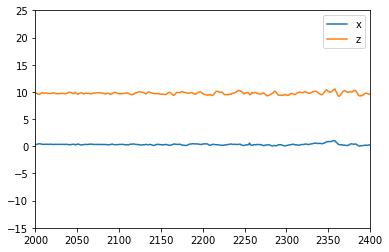

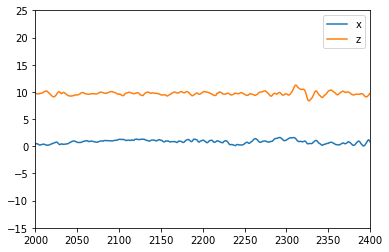

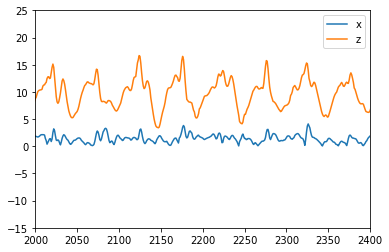

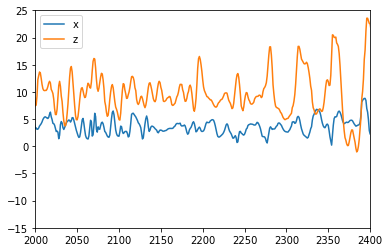

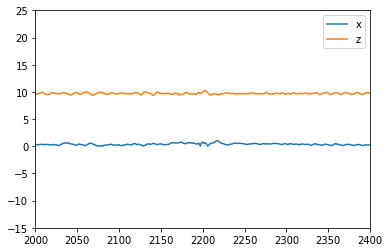

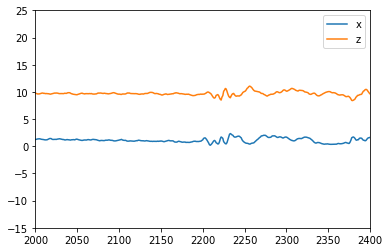

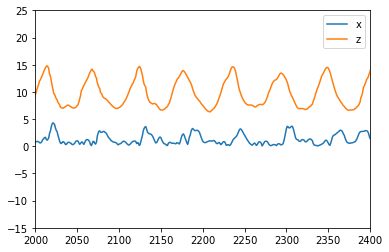

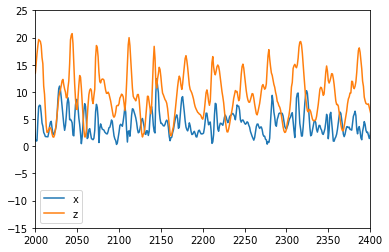

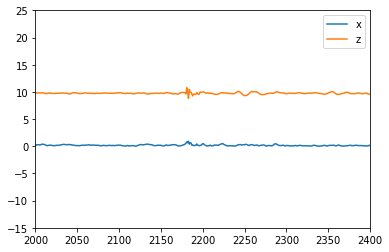

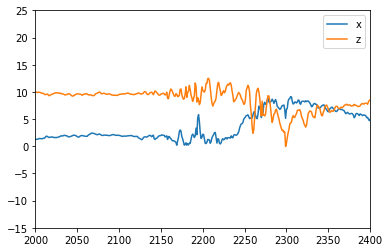

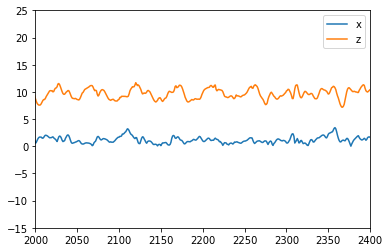

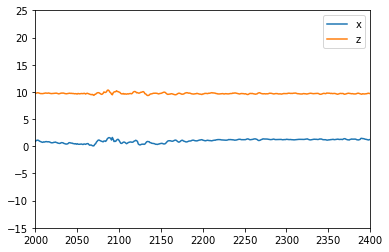

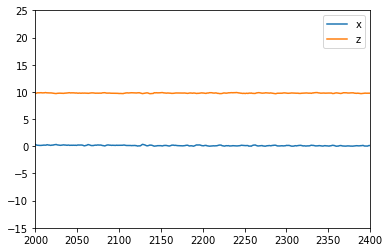

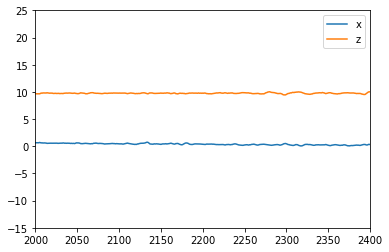

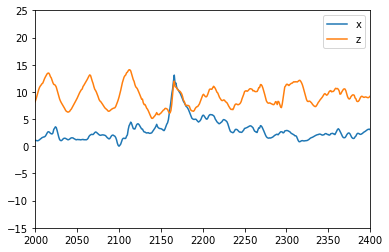

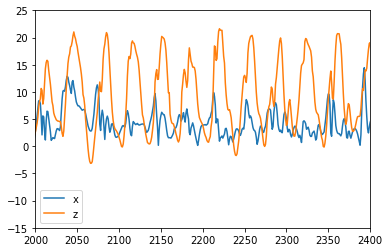

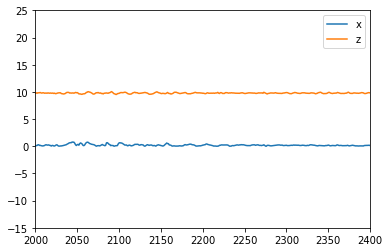

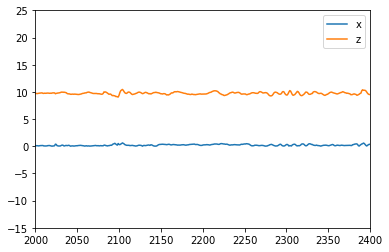

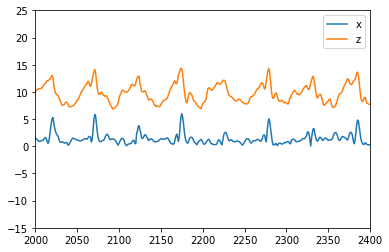

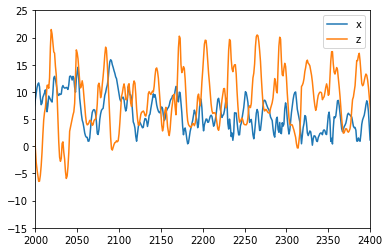

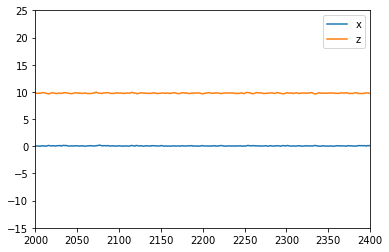

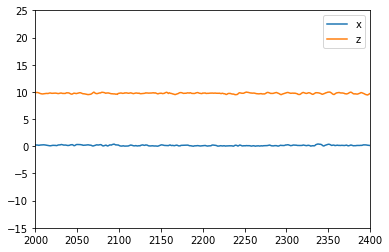

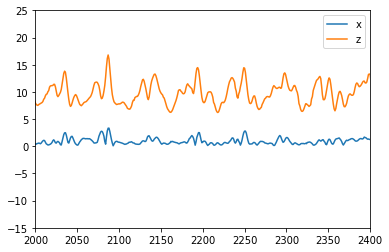

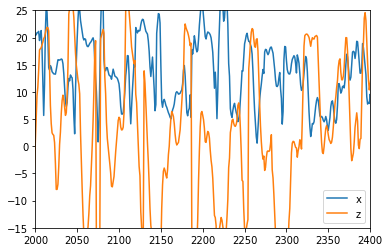

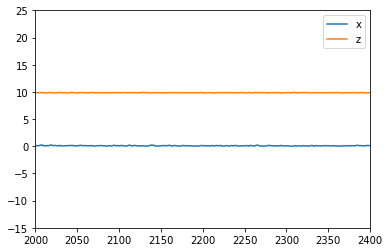

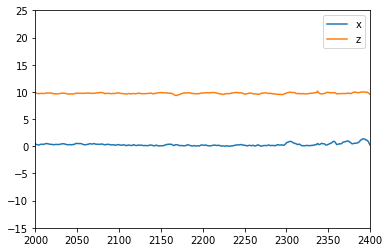

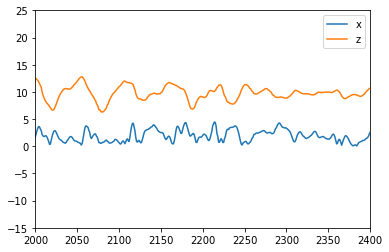

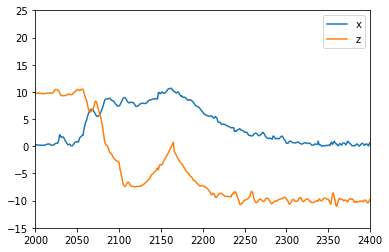

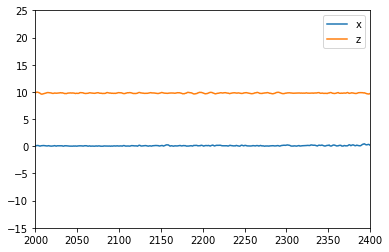

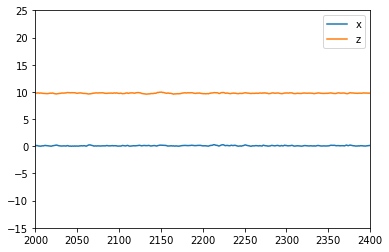

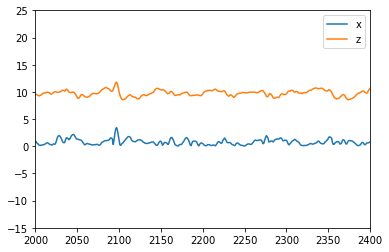

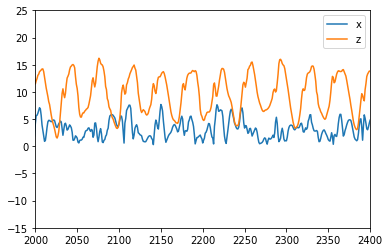

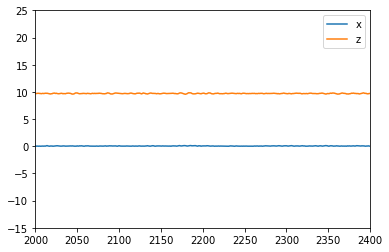

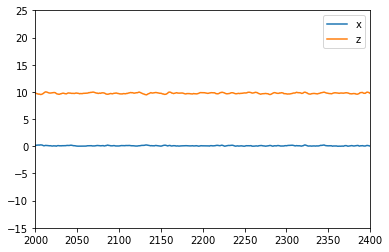

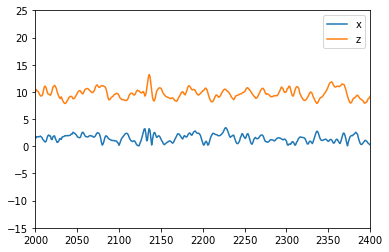

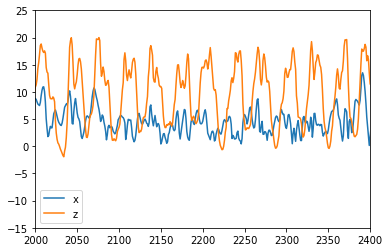

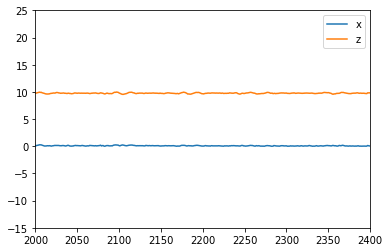

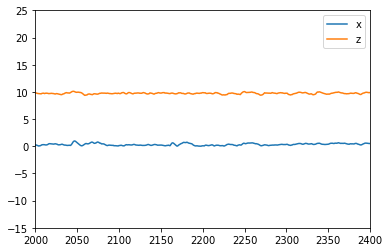

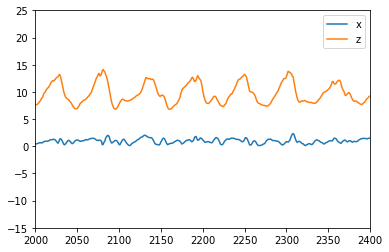

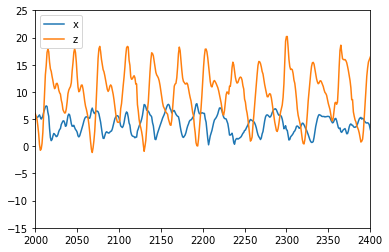

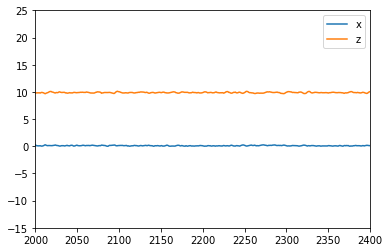

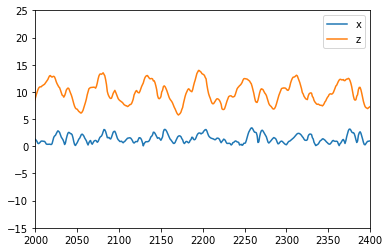

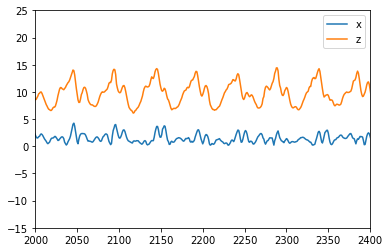

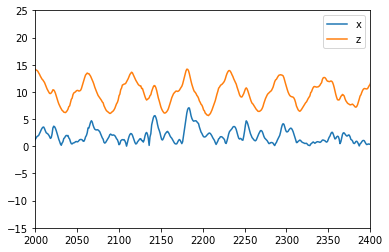

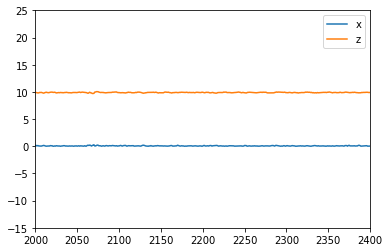

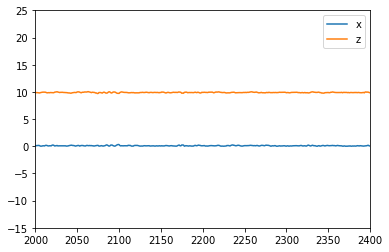

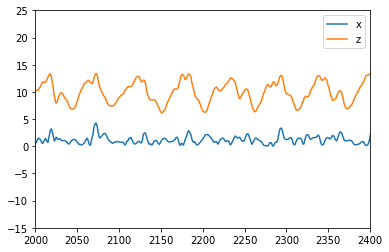

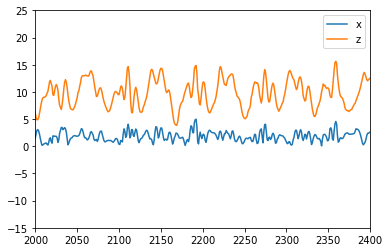

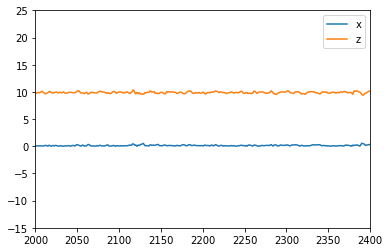

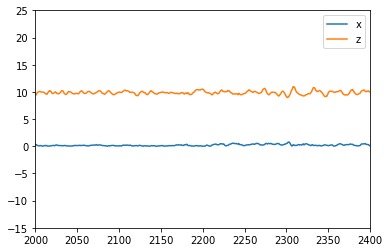

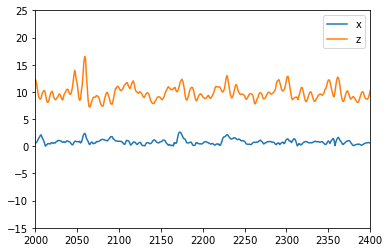

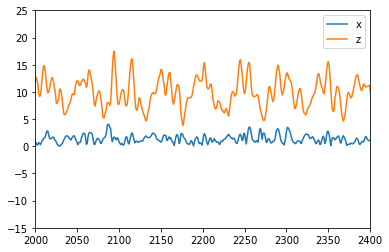

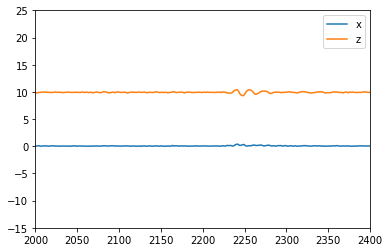

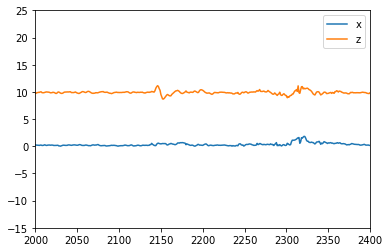

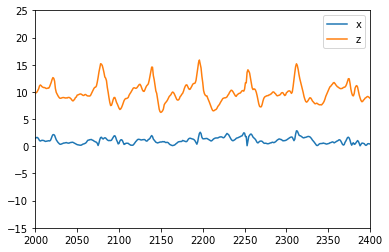

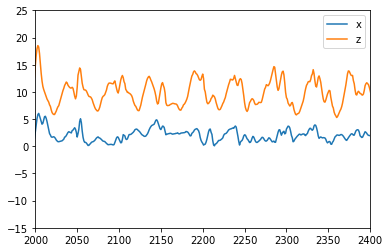

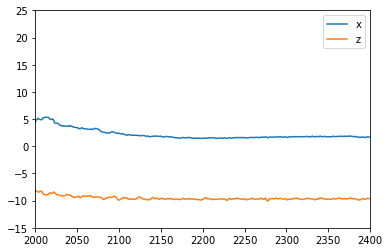

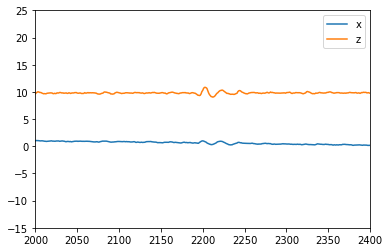

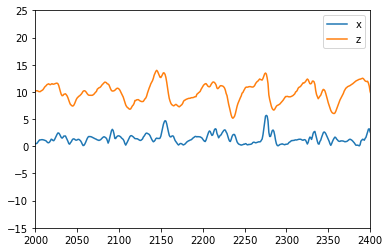

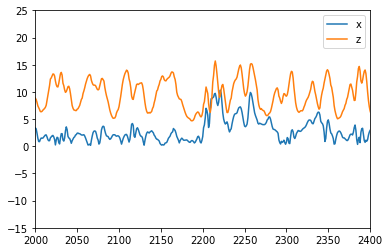

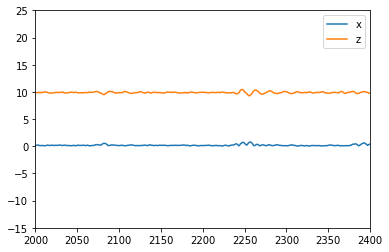

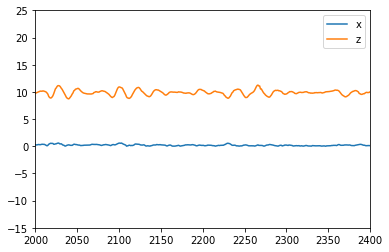

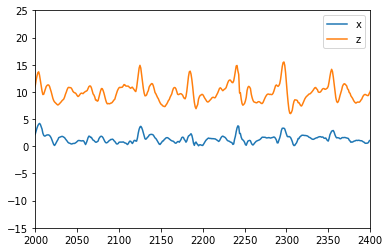

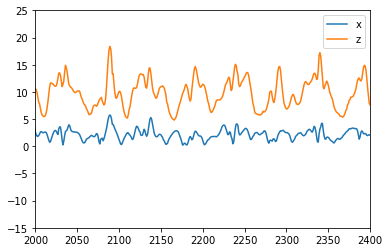

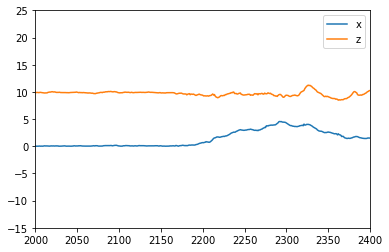

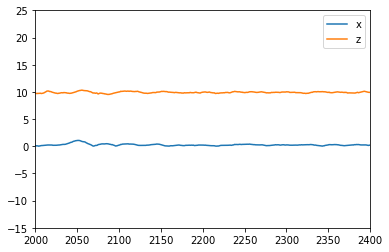

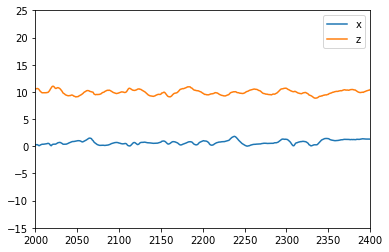

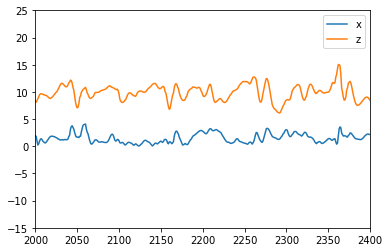

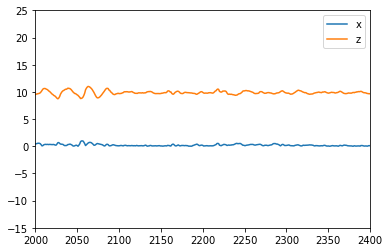

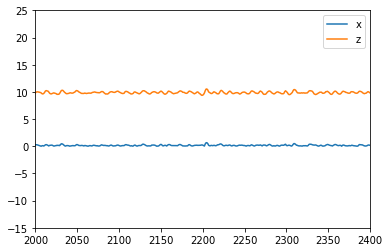

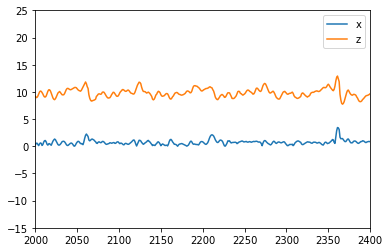

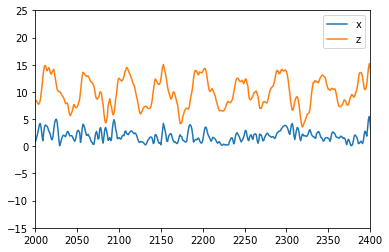

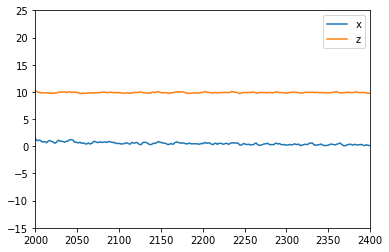

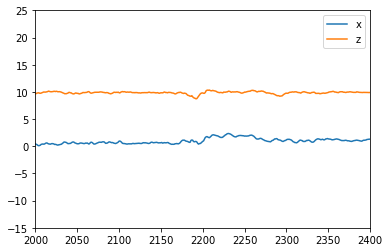

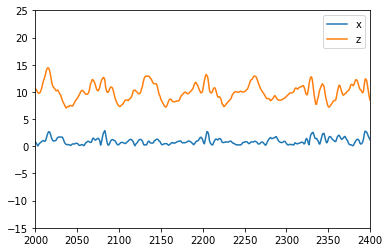

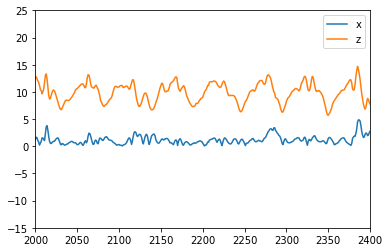

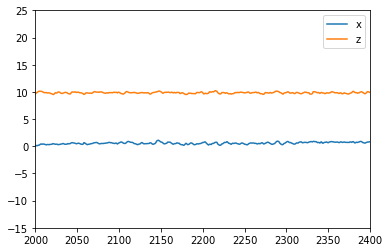

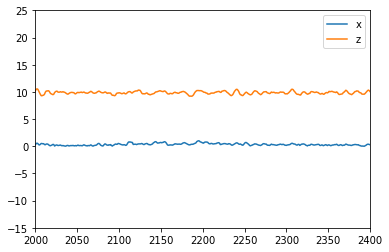

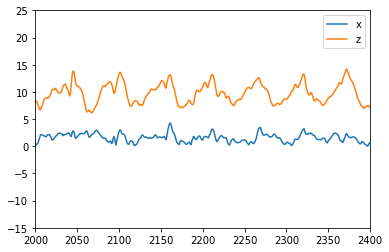

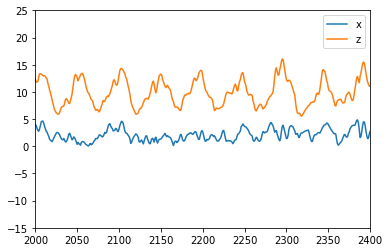

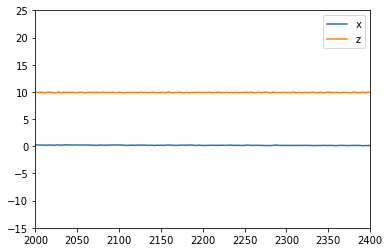

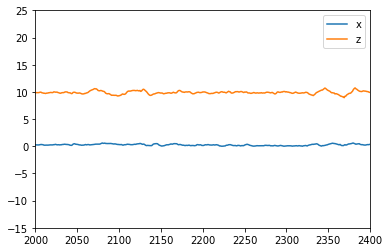

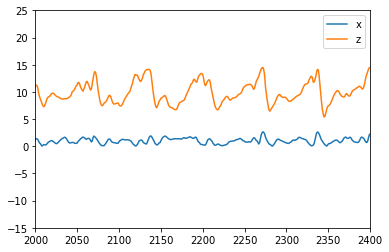

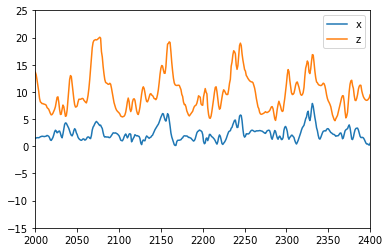

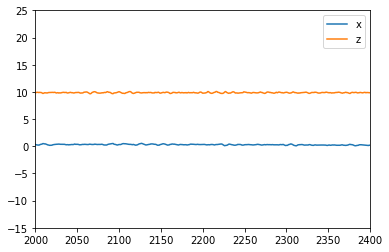

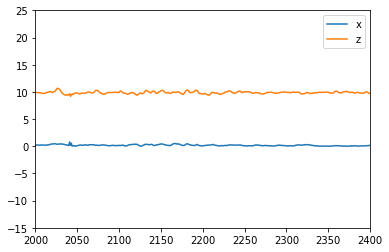

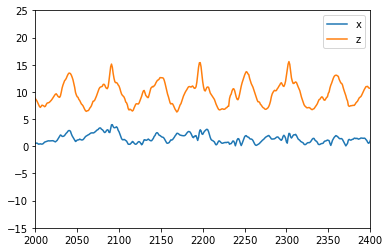

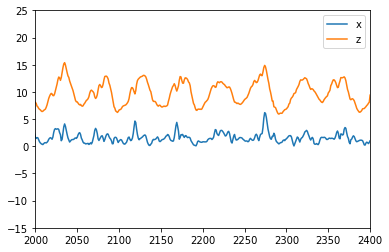

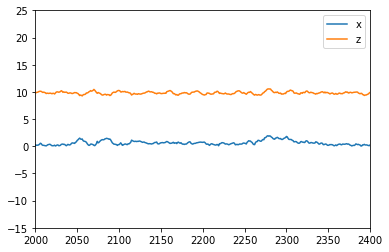

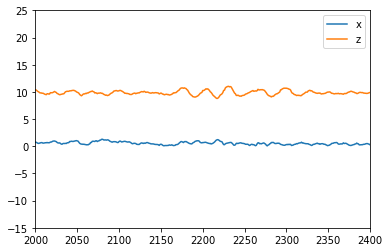

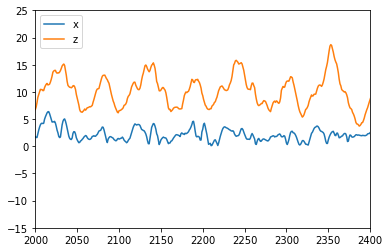

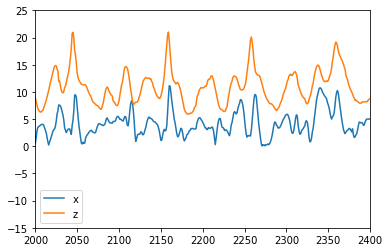

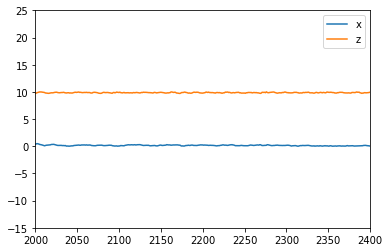

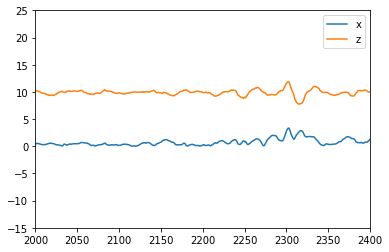

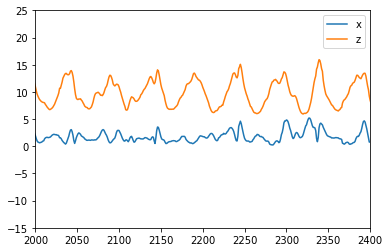

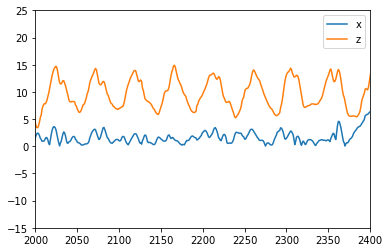

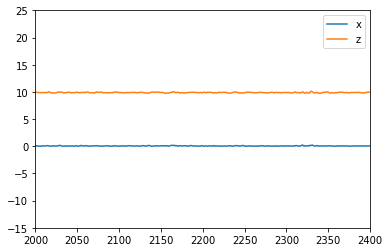

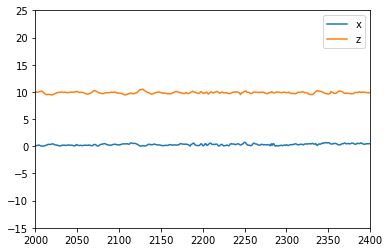

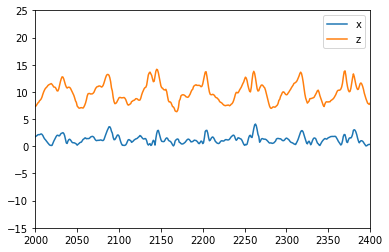

In [9]:
# plot x-acceleration and z-acceleration magnitudes for each dataset
for dataset in earth_adjusted_data:
    plt.xlim(2000, 2400)
    plt.ylim(-15, 25)
    plt.plot(dataset['x'])
    plt.plot(dataset['z'])
    plt.legend()
    plt.show()

Now that I have cleaned, formatted, and plotted my data, its time to extract my first features. 

Taking the average magnitude of acceleration might seem like a good step at this point, but on further examination of our plots, it doesn't make much sense, as the z-acceleration is clearly centered around 9.81 (the acceleration due to gravity). 

Taking the average would just be rediscovering the acceleration due to gravity on earth. Instead, what I am interested in is how much deviation we have from that stationary level--in other words, how much acceleration the phone is experiencing beyond what is required to keep in stationary. 

So, instead of averaging all of the datapoints, I will find the peaks of the data (for both x- and z-directions) and average* those peaks. 

This will give us an average peak magnitude of acceleration in the x and z directions, which will be my first two features. 

*I will actually use the median rather than the mean in this case, as there may be several huge outlier peaks and median is a more resistant measure of center. 

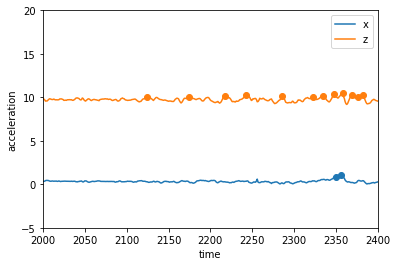

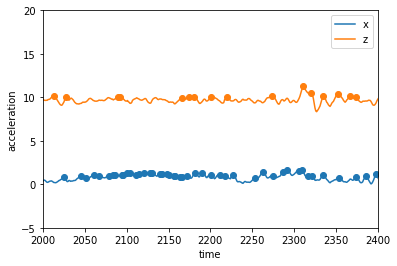

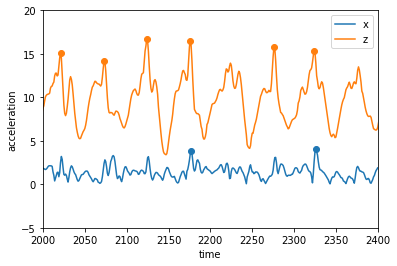

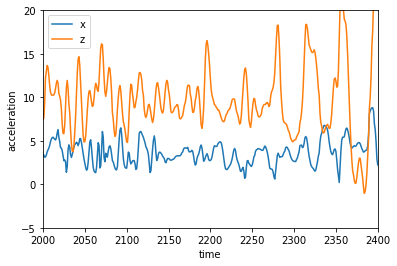

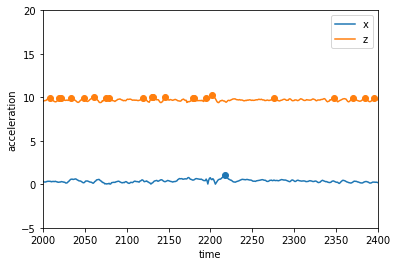

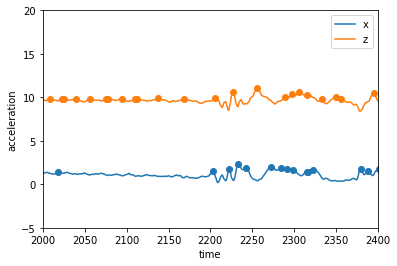

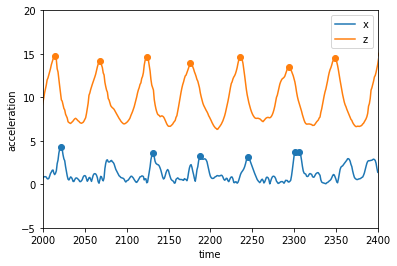

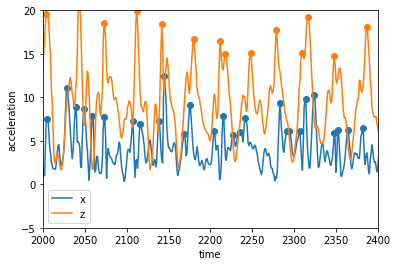

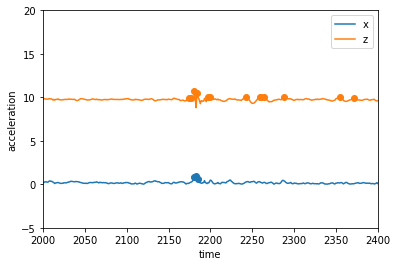

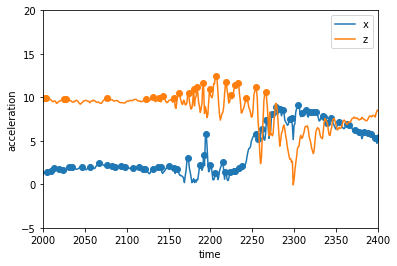

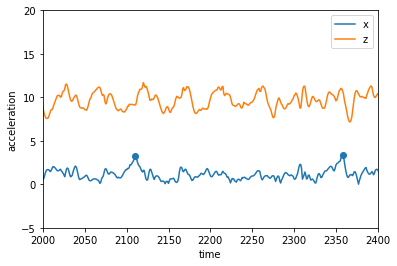

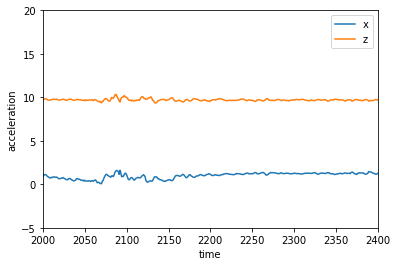

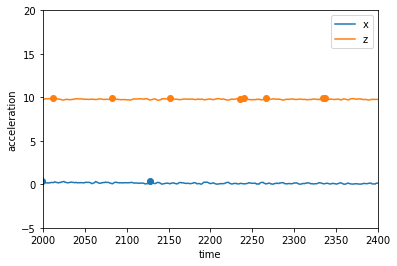

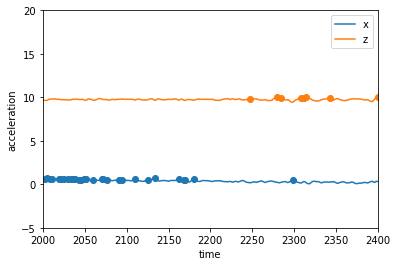

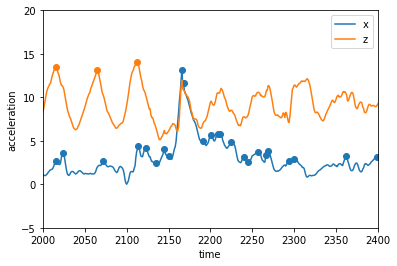

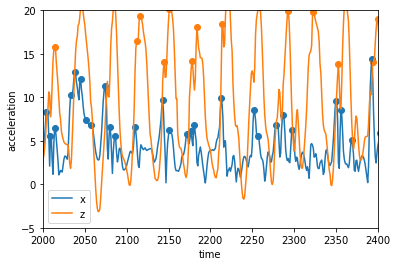

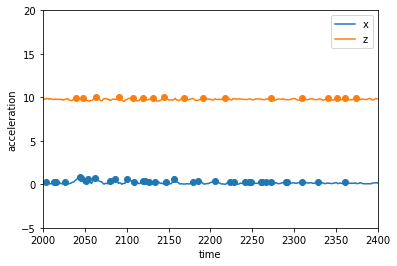

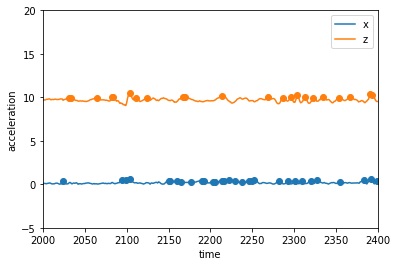

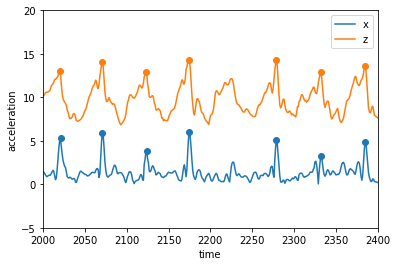

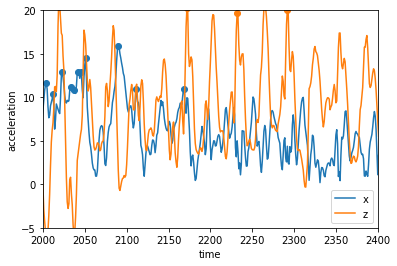

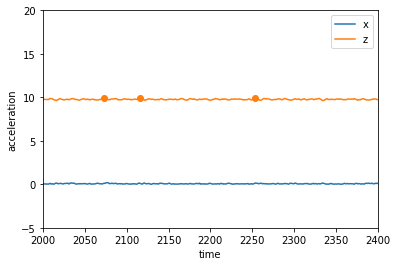

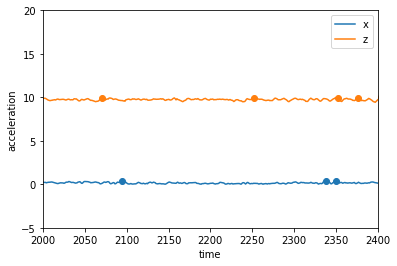

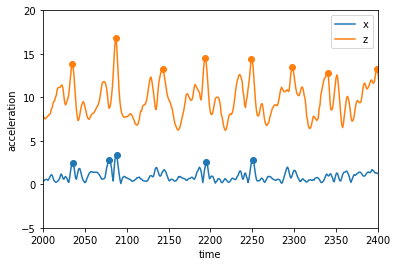

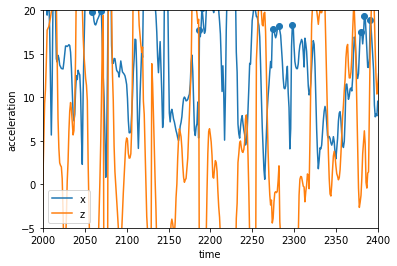

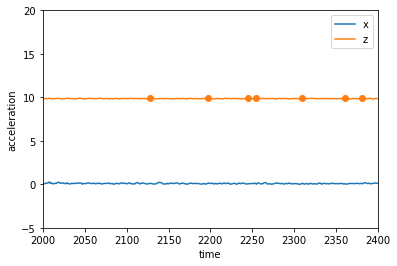

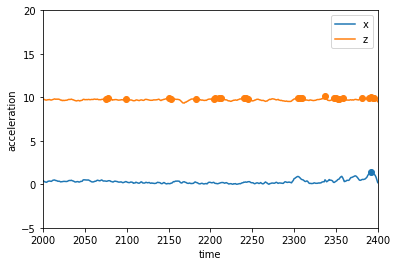

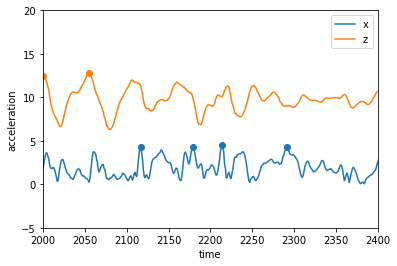

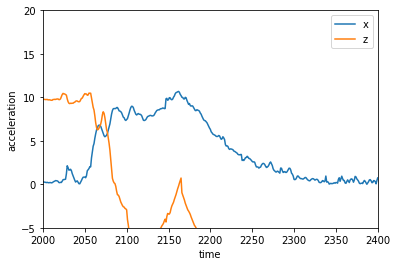

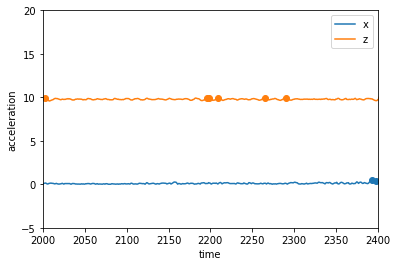

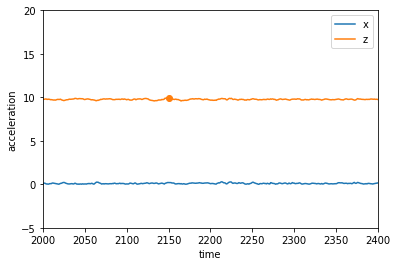

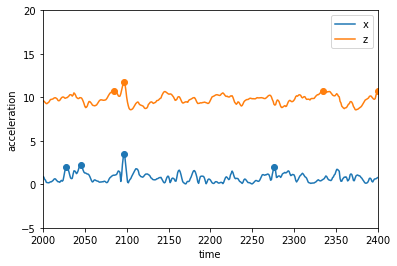

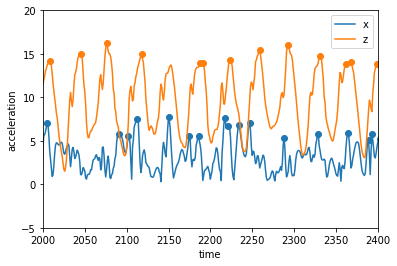

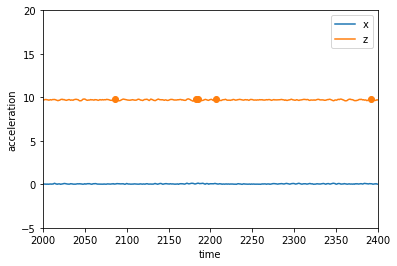

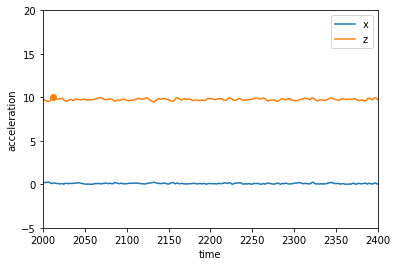

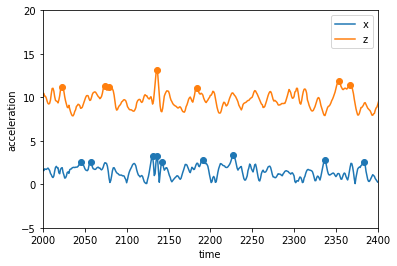

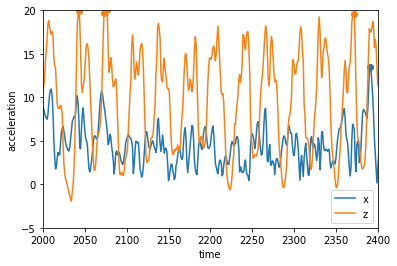

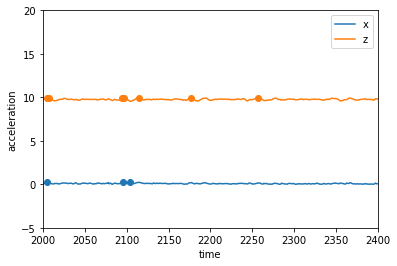

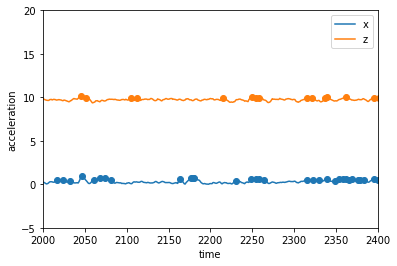

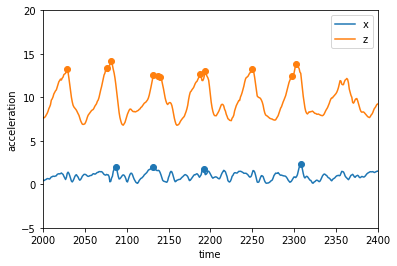

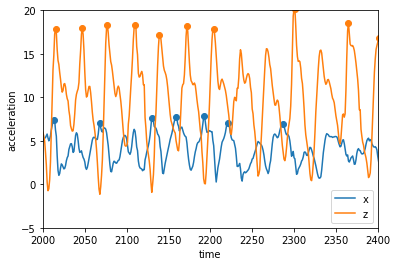

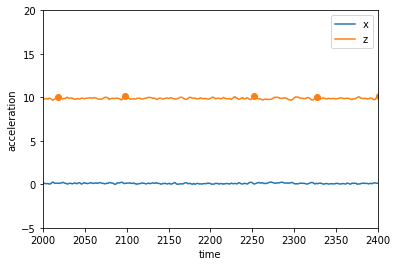

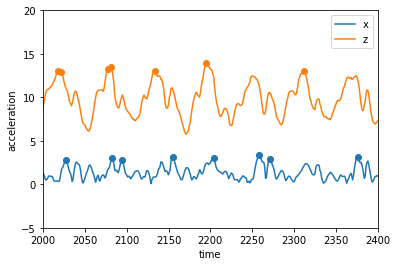

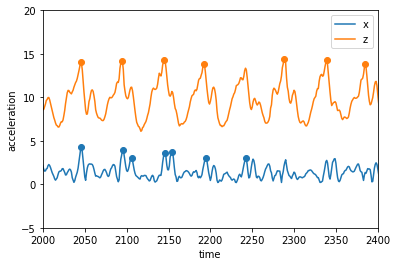

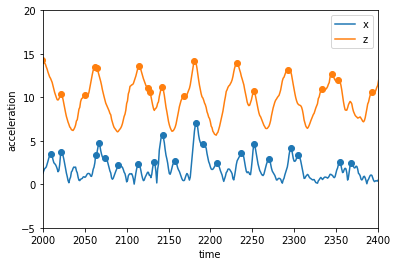

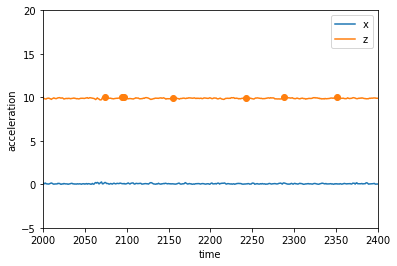

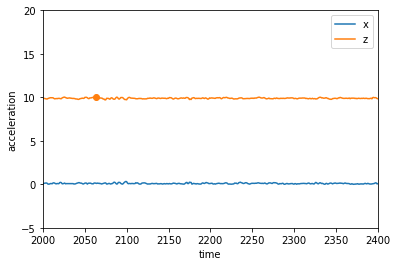

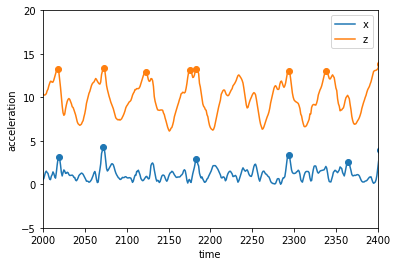

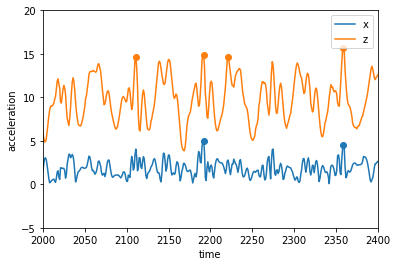

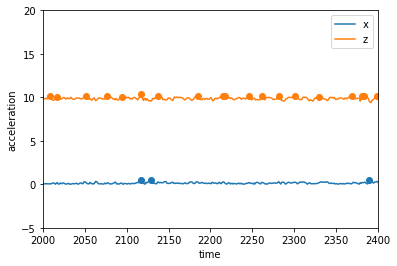

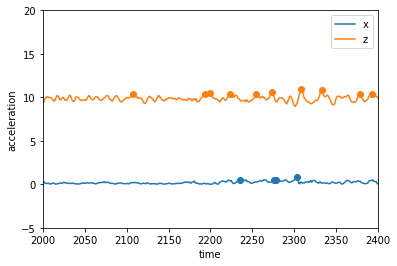

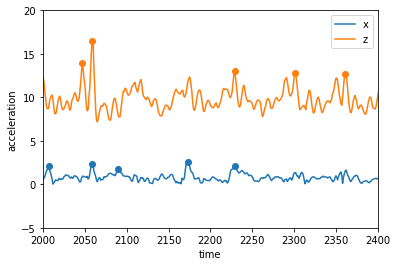

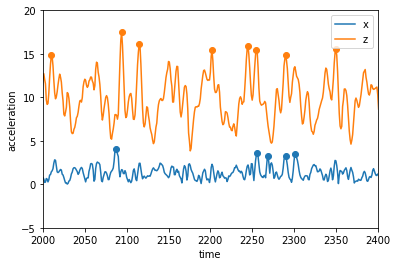

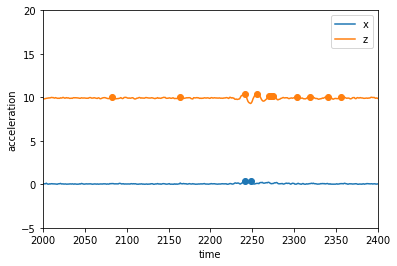

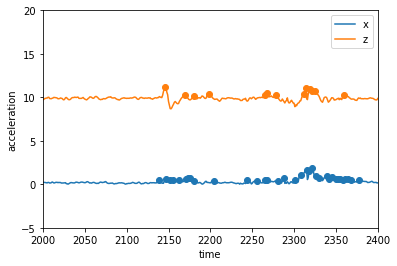

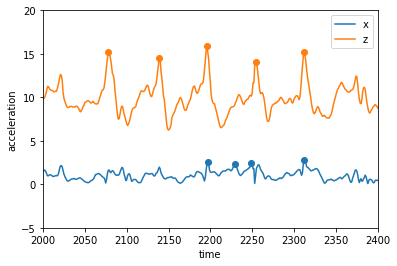

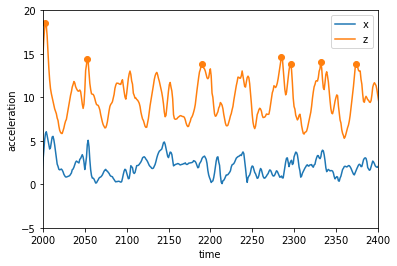

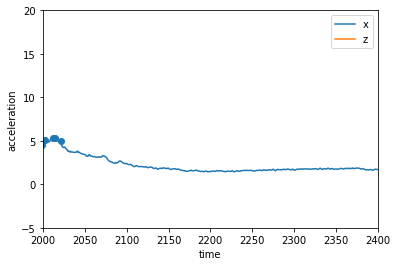

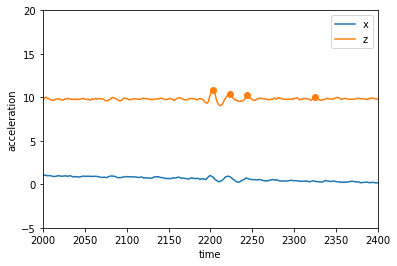

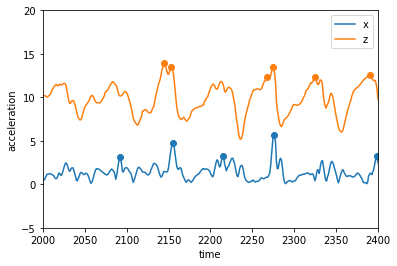

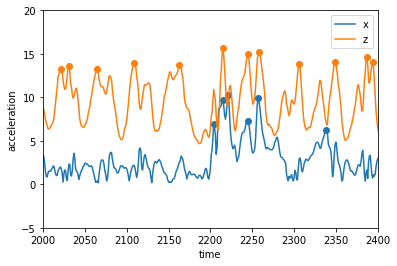

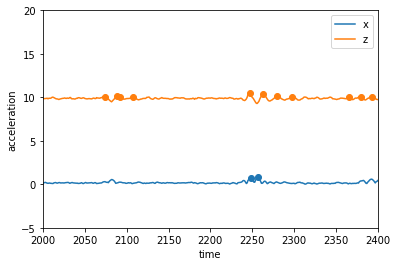

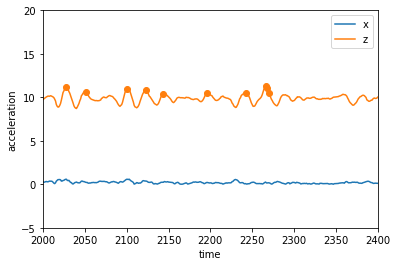

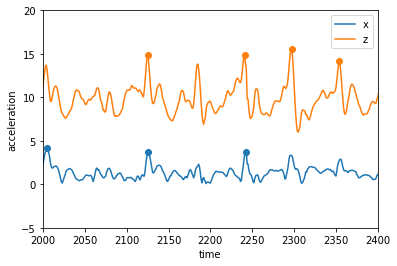

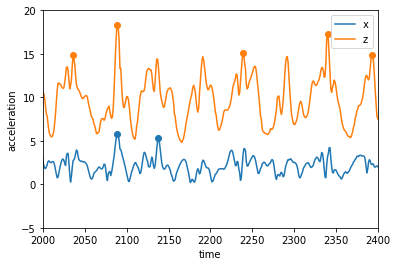

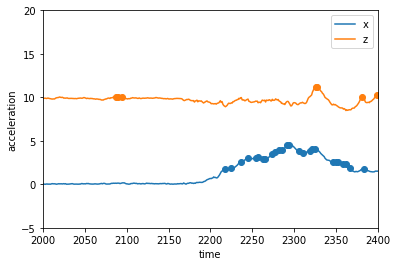

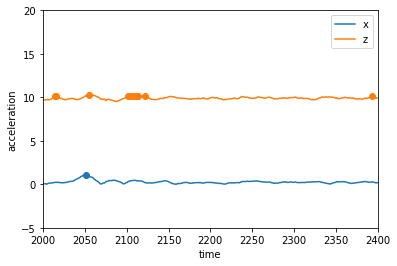

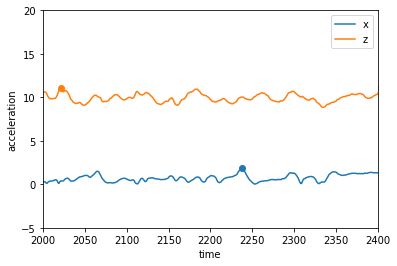

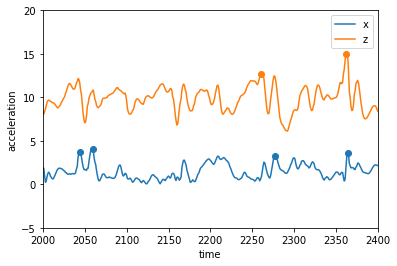

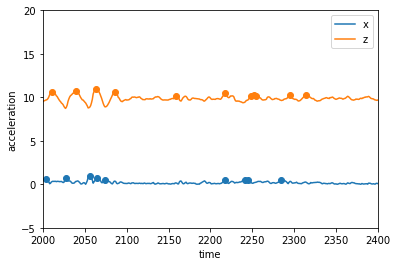

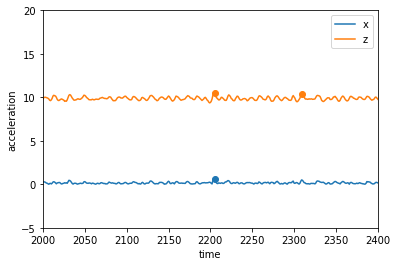

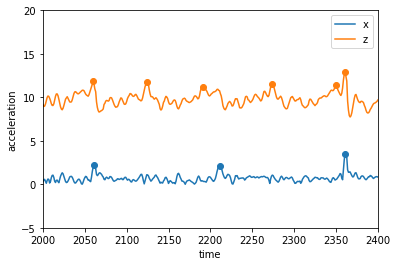

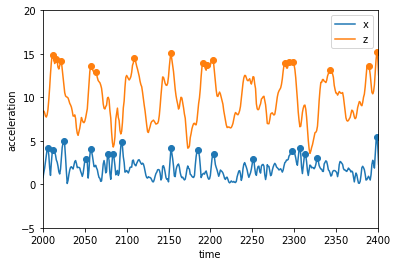

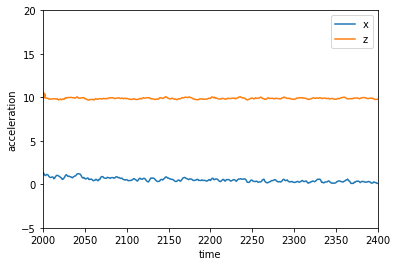

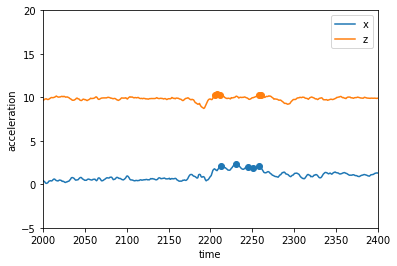

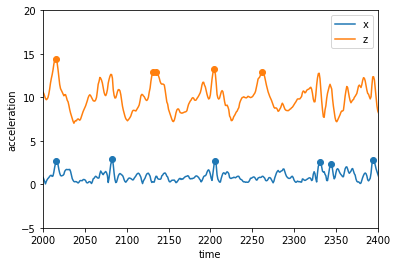

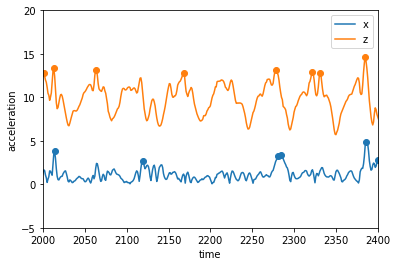

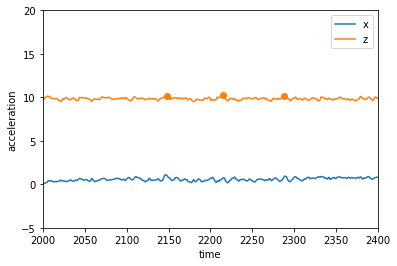

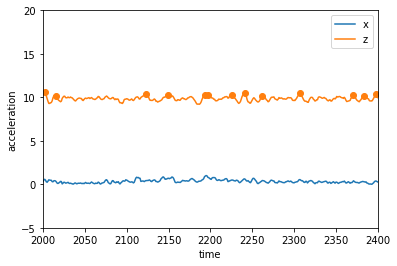

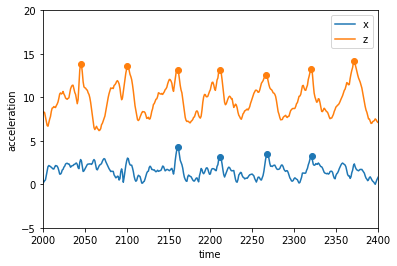

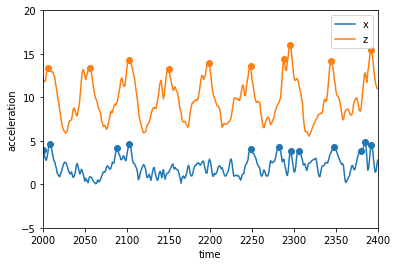

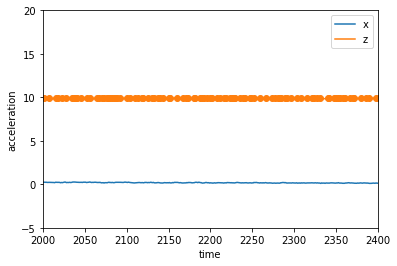

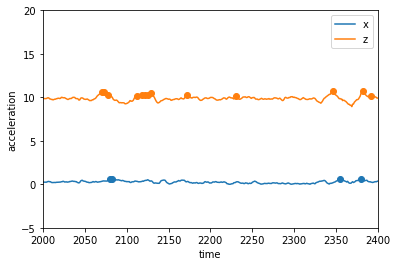

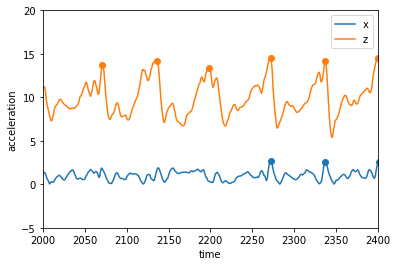

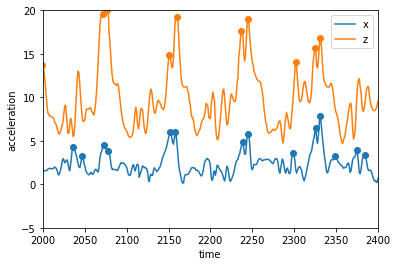

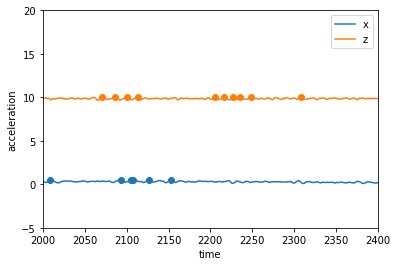

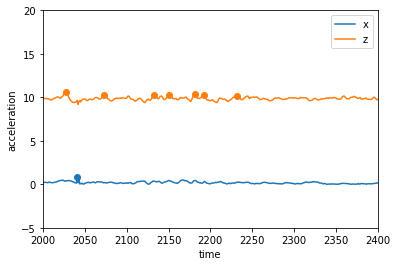

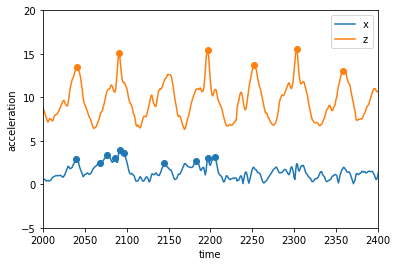

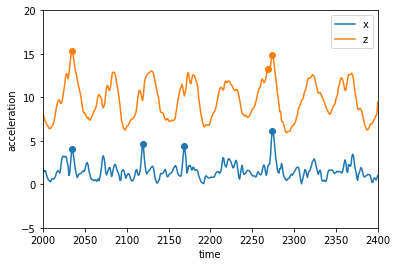

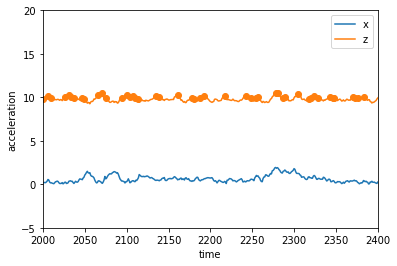

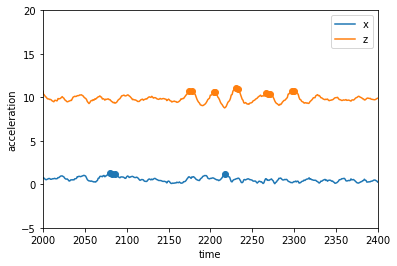

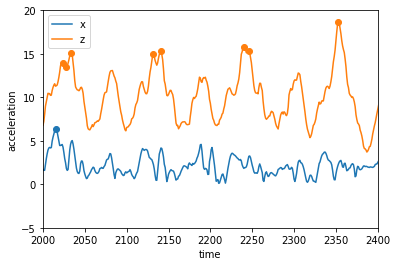

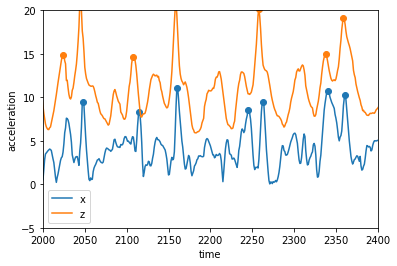

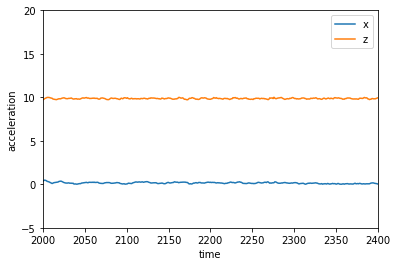

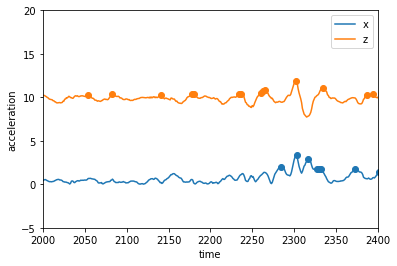

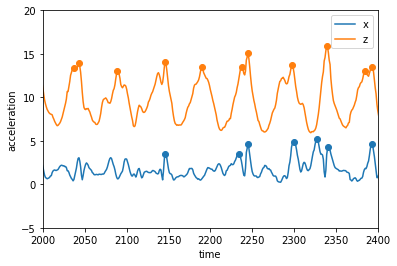

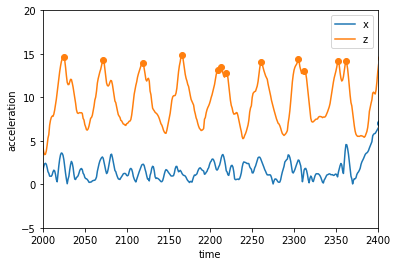

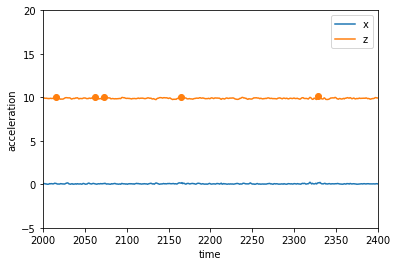

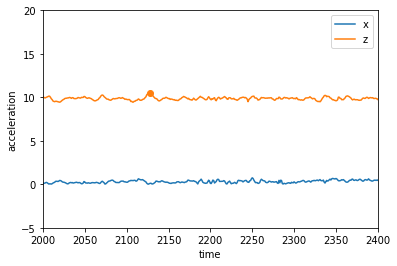

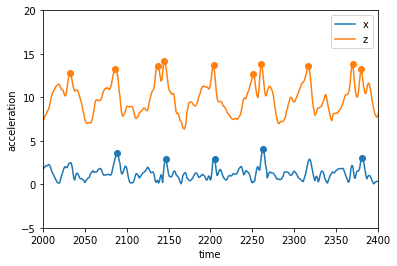

In [10]:
x_peaks = []
z_peaks = []

x_indexes = []
x_heights = []

z_indexes = []
z_heights = []

threshold = 1.0

for dataset in earth_adjusted_data:
    
    x = dataset['x']
    z = dataset['z']
    
    # continue lowering peak height threshold until there is a certain number of peaks.
    # this is to make sure that each dataset has a similar number of peaks
    while (len(x_indexes)/len(x)) < .015:
        # peakutils.indexes() finds all peaks above a given threshold and returns their x coordinates (indexes)
        x_indexes = peakutils.indexes(x, thres=threshold, min_dist=1)
        threshold = threshold - 0.01
    # add the heights to an array based on the fetched indexes
    for index in x_indexes:
        x_heights.append(x[index])
        
    # repeat for z-acceleration data
    threshold = 1
    while (len(z_indexes)/len(z)) < .015:
        z_indexes = peakutils.indexes(z, thres=threshold, min_dist=1)
        threshold = threshold - 0.01
    for index in z_indexes:
        z_heights.append(z[index])

    # plotting the data with the peaks and  resetting variables
    fig, ax = plt.subplots()
    ax.plot(x)
    ax.plot(z)
    ax.scatter(x_indexes, x_heights)
    ax.scatter(z_indexes, z_heights)
    plt.xlabel('time')
    plt.ylabel('acceleration')
    plt.xlim(2000, 2400)
    plt.ylim(-5, 20)
    plt.legend()
    plt.show()
    x_peaks.append(list(x_heights))
    z_peaks.append(list(z_heights))
    x_indexes = []
    z_indexes = []
    x_heights.clear()
    z_heights.clear()
    threshold = 1

In [11]:
# finding the median values for all of the peaks for each dataset

x_magnitudes = []
for data in x_peaks:
    x_magnitudes.append(np.median(data))
    
z_magnitudes = []
for data in z_peaks:
    z_magnitudes.append(np.median(data))

Great--I've got two solid features! I could probably do some decent classification just based on these magnitudes. However, I would like to be even more accurate, and there is still a lot to be extracted from this data. 

For my next features, I would like to begin to examine the periodicity of the data. Simply looking at the plots shows us that the walking and running data has signifcant periodicity, while the sitting and standing data seems to lack this. This is rather intuitive, but I would like to quantify this into a feature.

To accomplish this, I will use a tool called auto-corellation. The data will be overlayed on istelf, and a new graph will emerge which essentially extracts any periodic motion from the noisy initial data. 

This data will then be normalized so that it is on the same scale, and the peaks and troughs will be found. 

Two features can then be extracted from this graph--the amplitude of the resulting waves, or PROMINENCE of the singal, and the period of the waves, or STEPSIZE of the signal. 

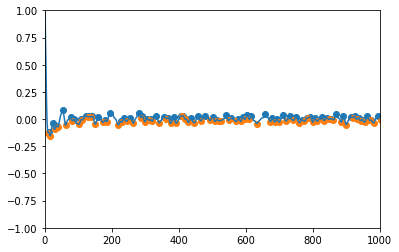

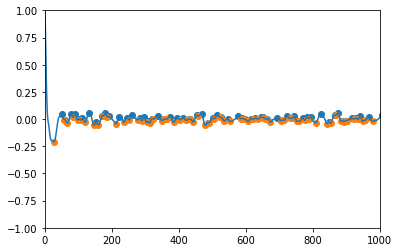

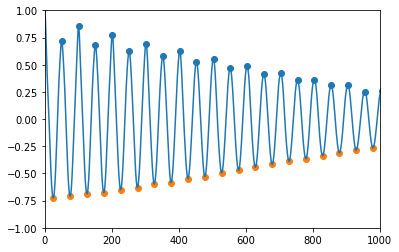

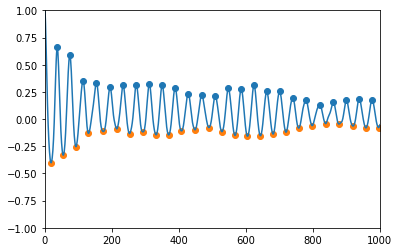

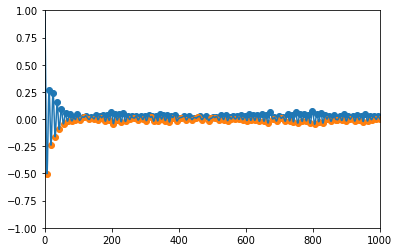

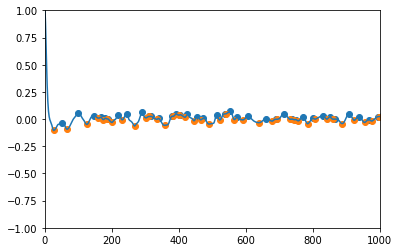

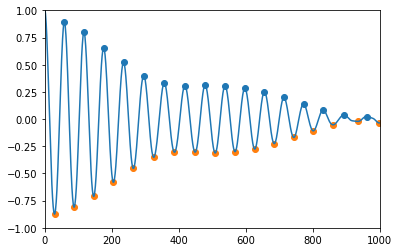

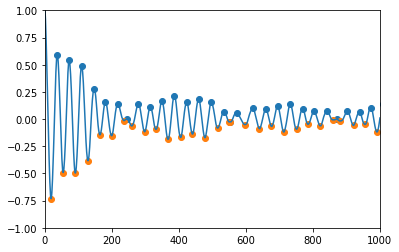

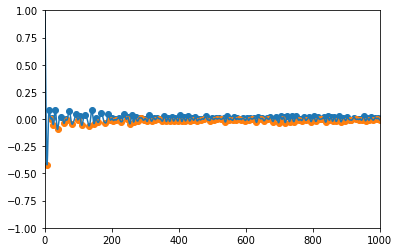

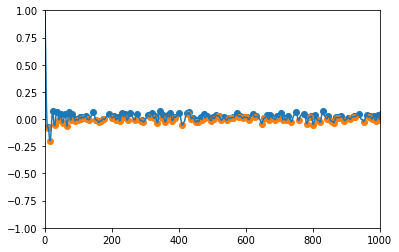

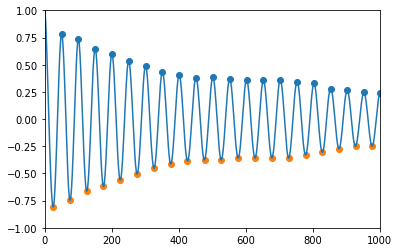

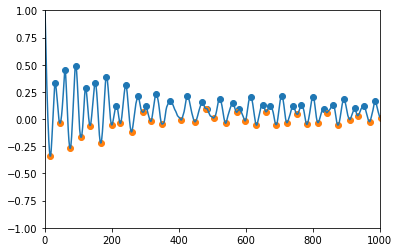

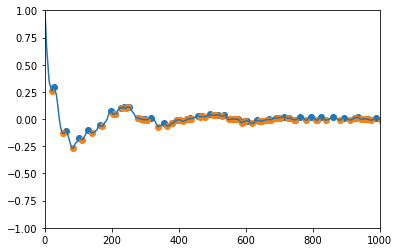

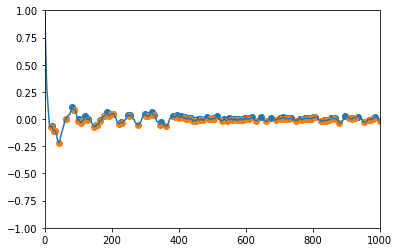

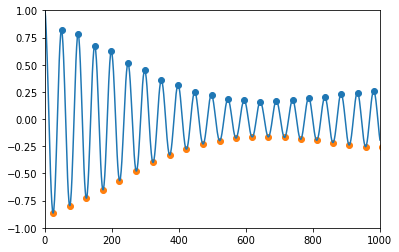

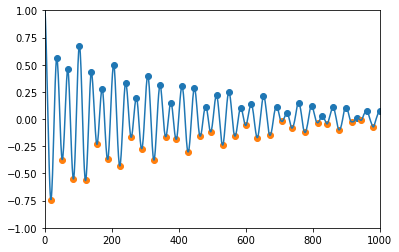

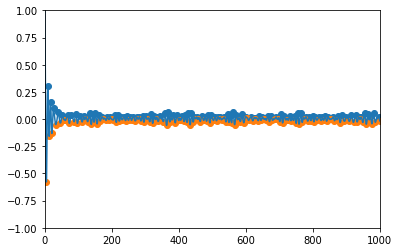

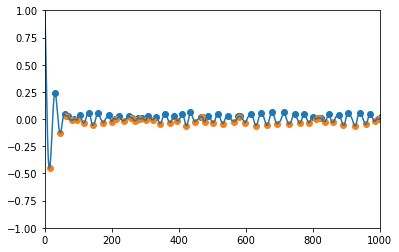

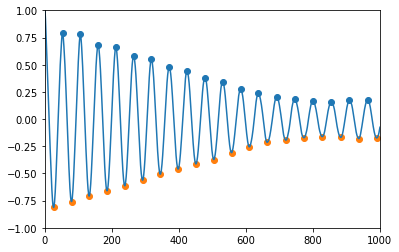

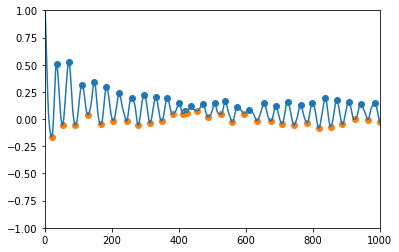

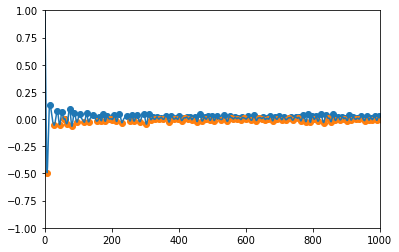

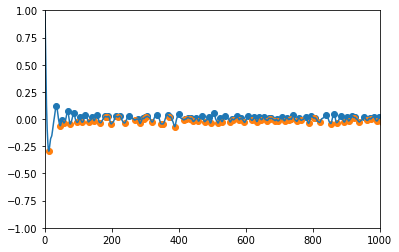

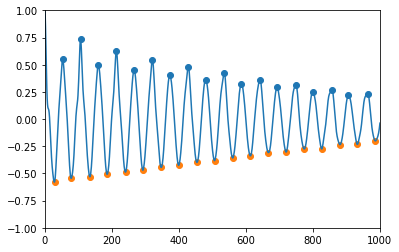

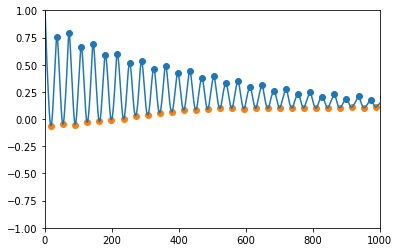

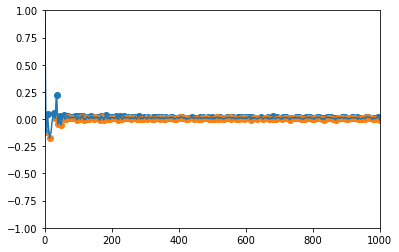

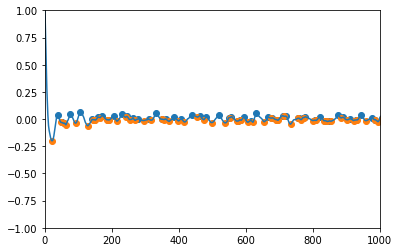

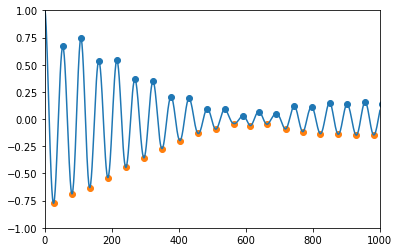

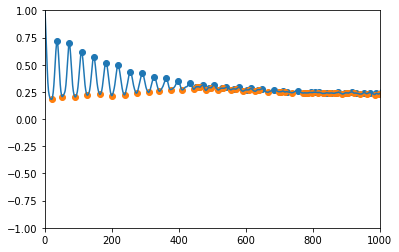

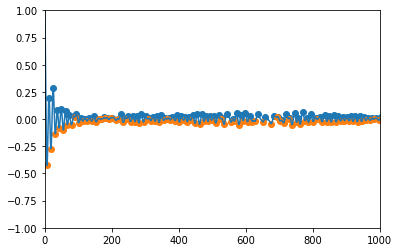

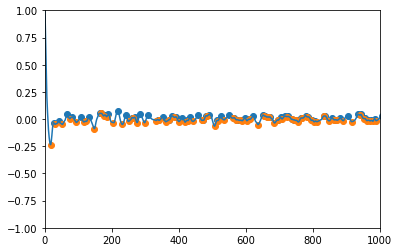

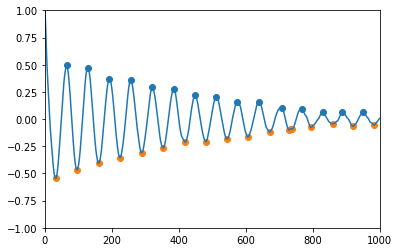

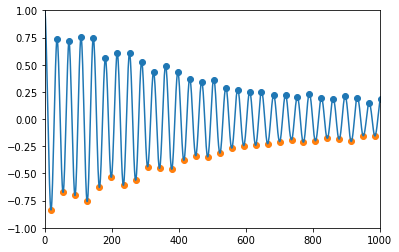

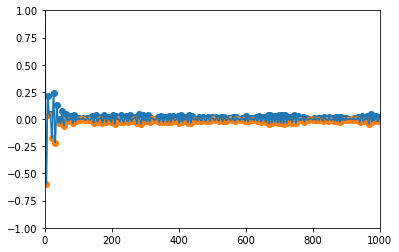

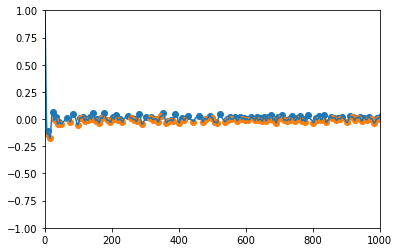

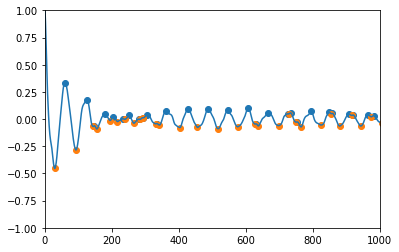

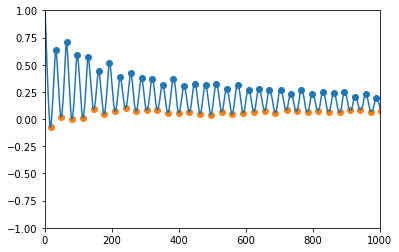

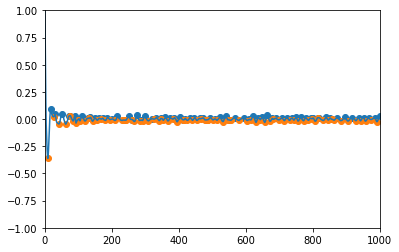

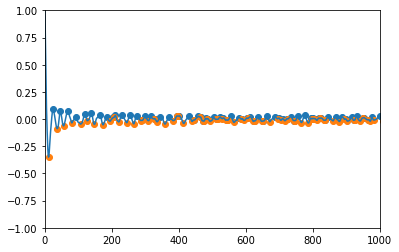

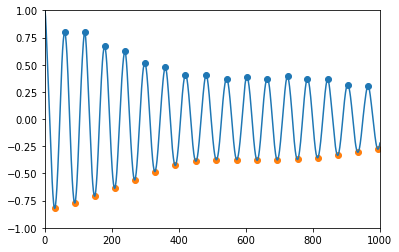

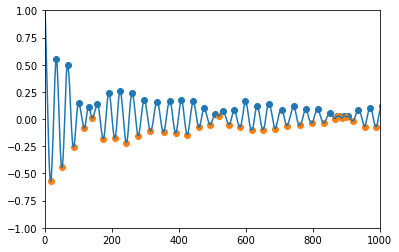

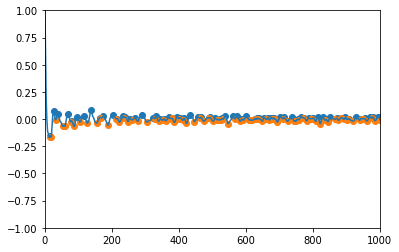

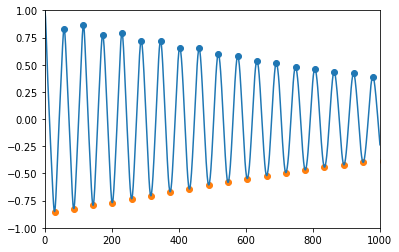

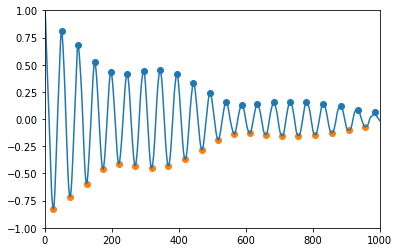

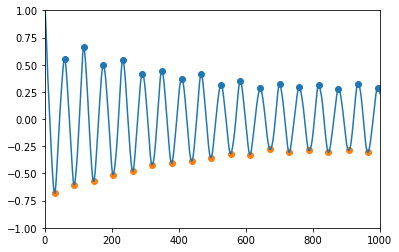

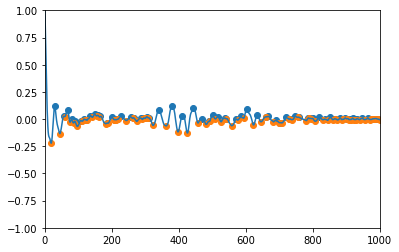

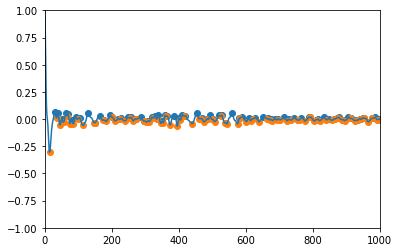

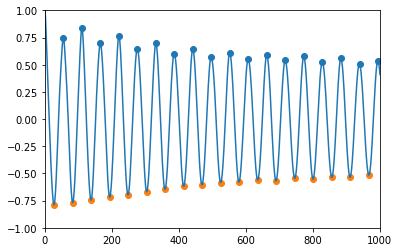

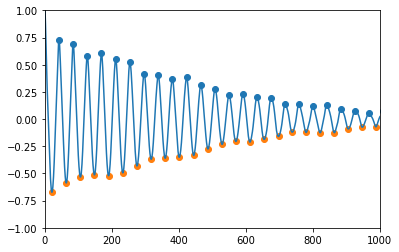

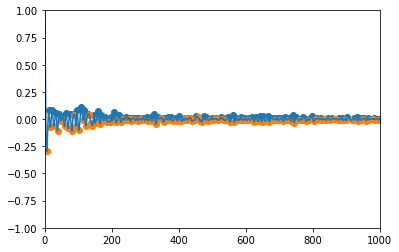

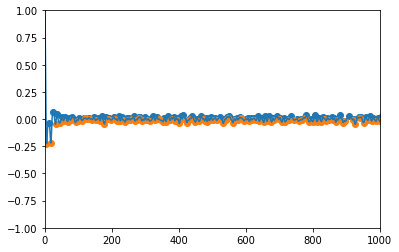

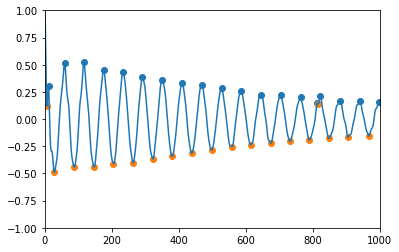

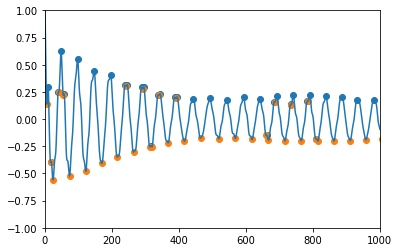

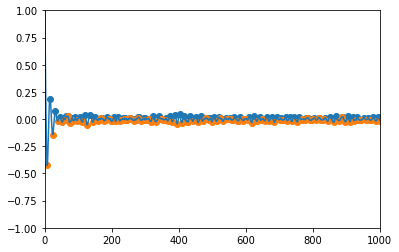

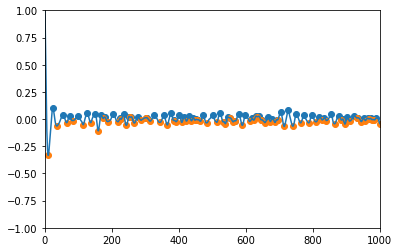

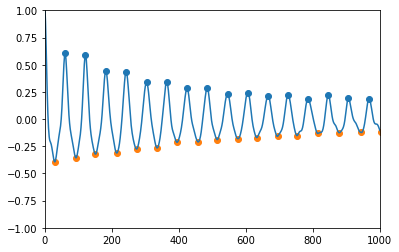

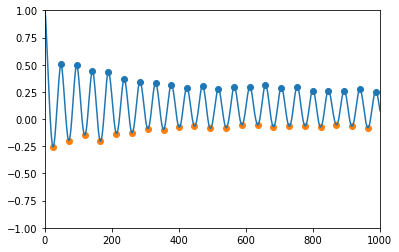

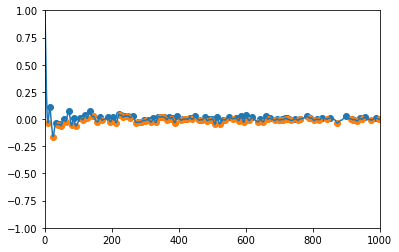

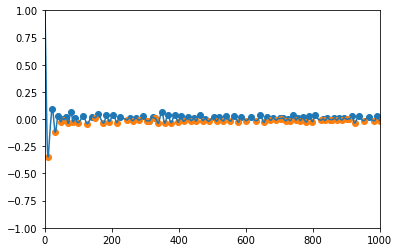

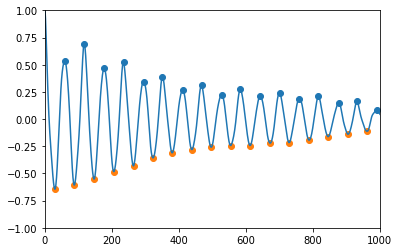

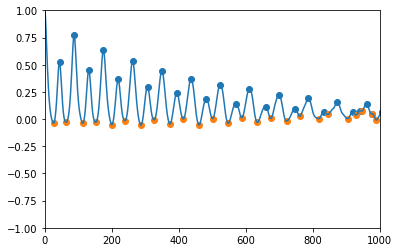

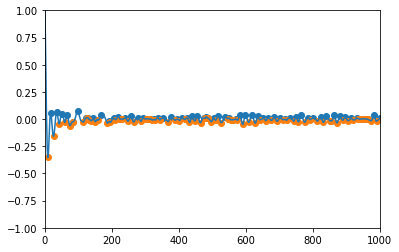

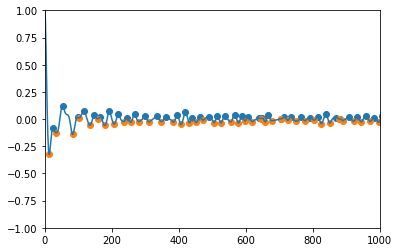

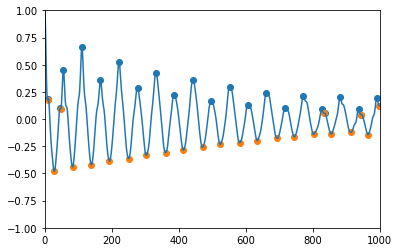

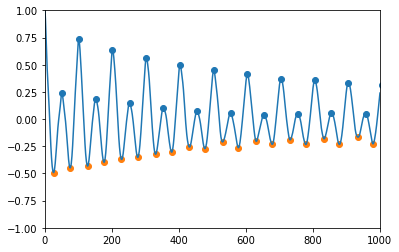

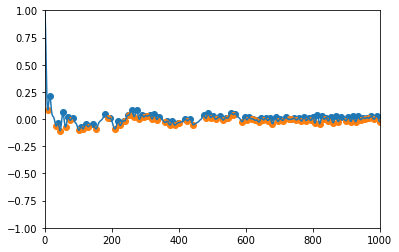

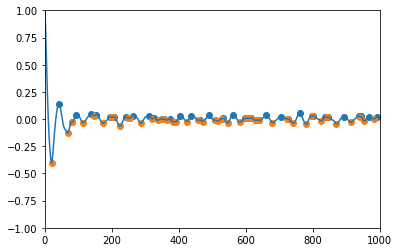

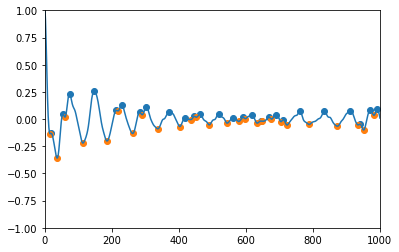

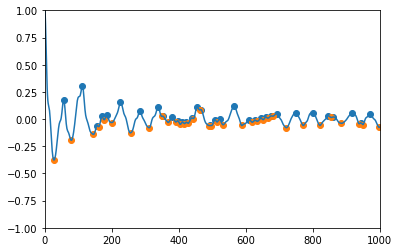

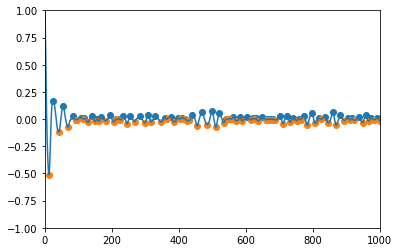

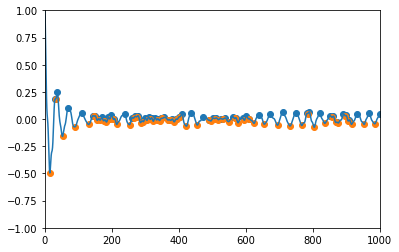

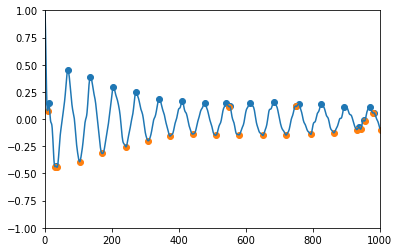

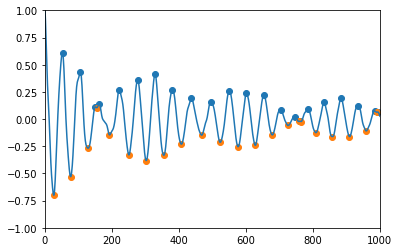

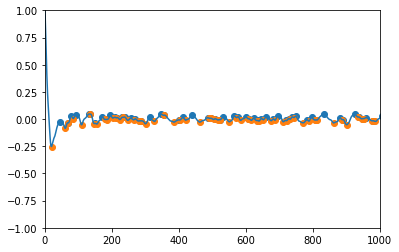

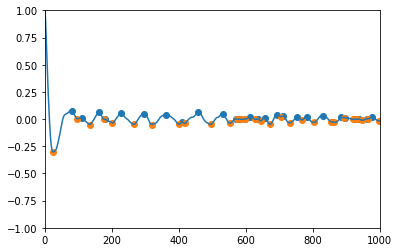

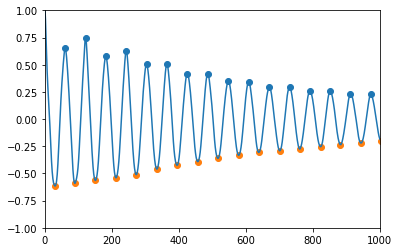

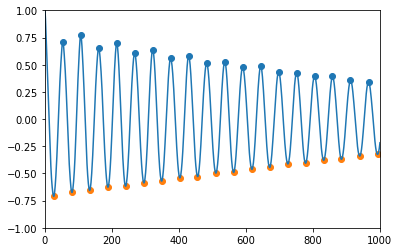

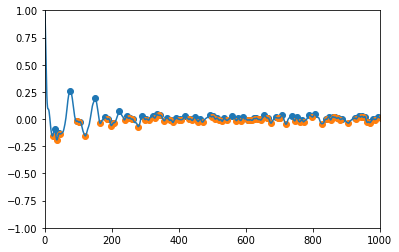

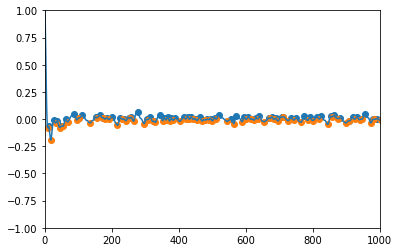

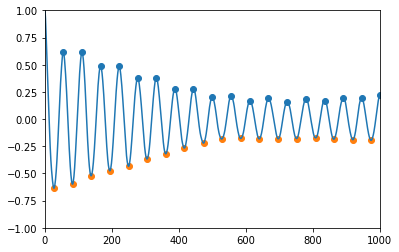

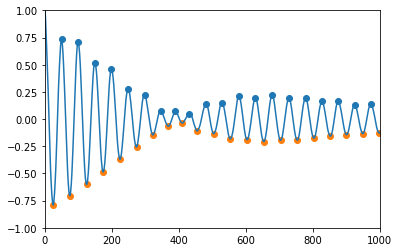

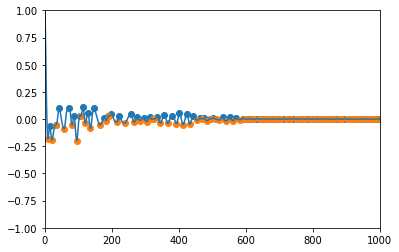

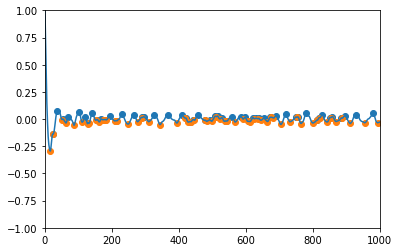

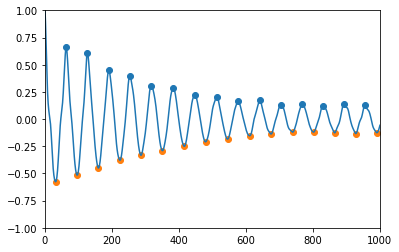

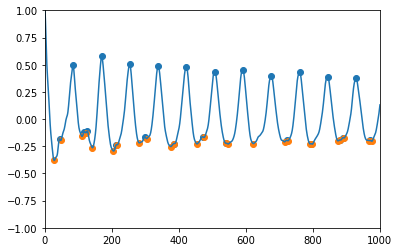

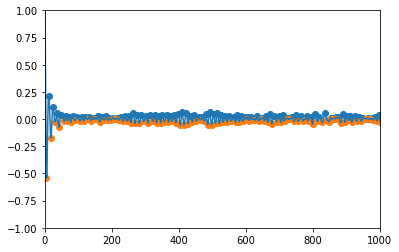

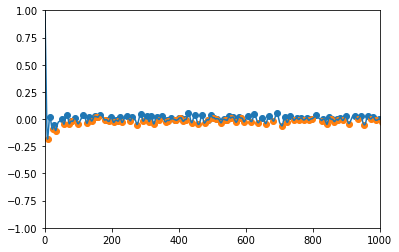

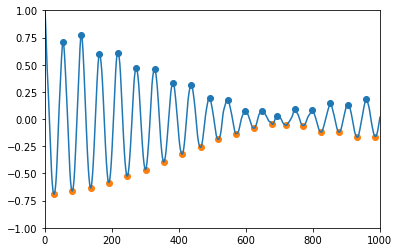

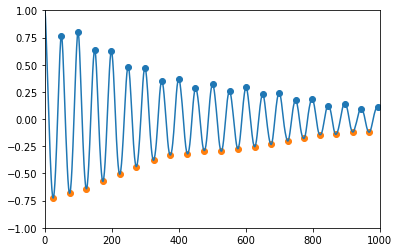

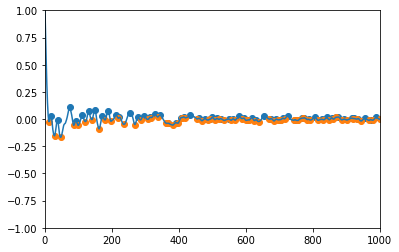

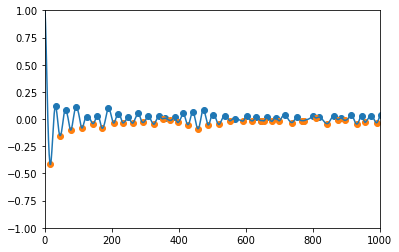

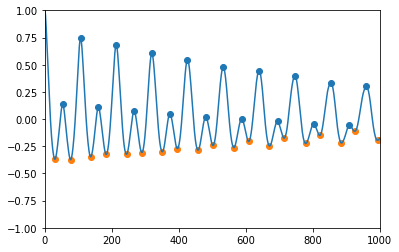

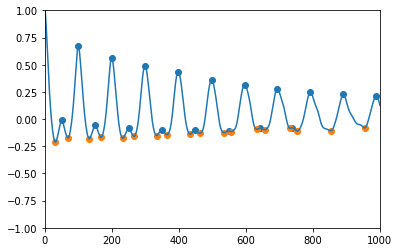

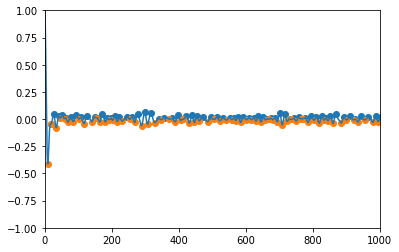

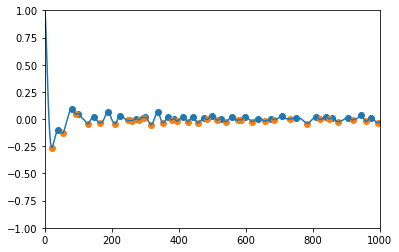

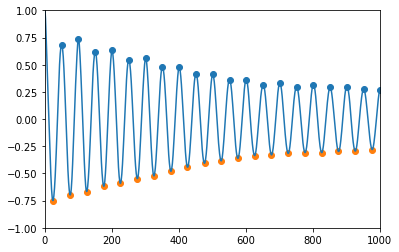

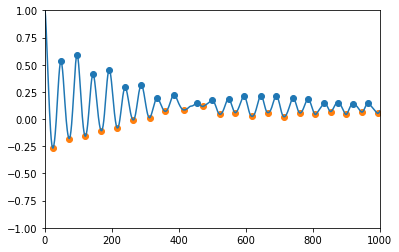

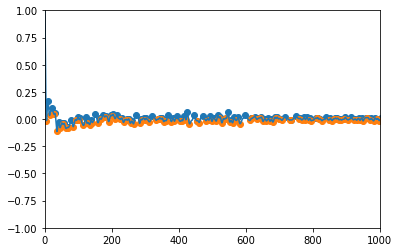

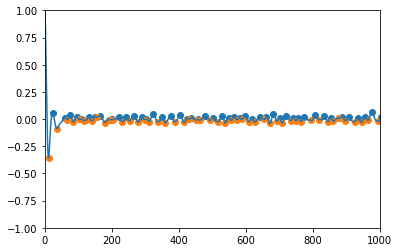

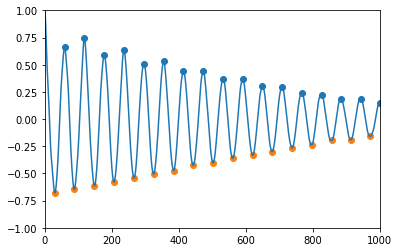

In [12]:
peaks = []
troughs = []

maxima_x = []
maxima_y = []

minima_x = []
minima_y = []

for count, datas in enumerate(earth_adjusted_data):
    
    # combine data into a single vector
    data = np.sqrt(datas['x']**2 + datas['z']**2)
    
    # subtract the mean to center around 0
    data = data - np.mean(data)
    
    # auto correlation
    data = np.correlate(data, data, mode = 'same')
    
    # eliminate first half of data due to symmetry of auto correlation
    data = data[np.int(len(data)/2):]
    
    # normalize data
    data = data / np.max(data)

    # find local maxima and minima (peaks and troughs)
    maxima_x = signal.argrelextrema(data, np.greater)
    minima_x = signal.argrelextrema(data, np.less)

    peaks.append([])
    troughs.append([])
    
    for x in maxima_x[0]:
        peaks[count].append((x, data[x]))
        maxima_y.append(data[x])
        
    for x in minima_x[0]:
        troughs[count].append((x, data[x]))
        minima_y.append(data[x])
    
    # plot correlation figures with peaks and troughs 
    fig, ax = plt.subplots()
    ax.plot(data)
    plt.ylim(-1, 1)
    plt.xlim(0, 1000) 
    ax.scatter(maxima_x, maxima_y)
    ax.scatter(minima_x, minima_y)
    plt.show()
    
    # reset reused variables
    maxima_x = []
    maxima_y.clear()
    minima_x = []
    minima_y.clear()


In [13]:
stepsize = []
prominence = []

for count, dataset in enumerate(peaks):
    
    # calculation of stepsize
    frame = pd.DataFrame(dataset, columns = ['x', 'y'])
    stepsize.append(frame.loc[1]['x'] - frame.loc[0]['x'])
    
    # calculation of prominence
    troughs_frame = pd.DataFrame(troughs[count], columns = ['x', 'y'])
    prominence.append(frame.loc[0]['y'] - troughs_frame.loc[0]['y'])

Awesome! Now I have 4 good features. It's almost time to start applying machine larning models to this data!

Before I do so, there are a few outlier data points that I've been keeping an eye on throughout the process. For a couple, it is clear that they have simply been mis-labeled, so I will simply re-label those points. Thre is also one data point that is such an outlier  I'm just going to drop the row. I don't want to be overly selective, but with significant outliers, its totally ok to trim the data if it results in a better model. 

Once I've finished this final round of cleaning and formatting, I'll take one last look at some scatterplots of the data to make sure everything is good and proceed to working with classification models!

In [26]:
# adjusting some mislabeled data
labels[27] = 3
labels[41] = 2

In [27]:
# setting up the final dataframe
final_data = pd.DataFrame()
final_data['x-magnitude'] = x_magnitudes
final_data['z-magnitude'] = z_magnitudes
final_data['stepsize'] = stepsize
final_data['prominence'] = prominence
final_data['label'] = labels

In [30]:
# dropping a significant outlier and resetting the index
final_data.drop([51], inplace = True)
final_data.reset_index(inplace = True)
final_data.drop(['index'], axis = 1, inplace = True)

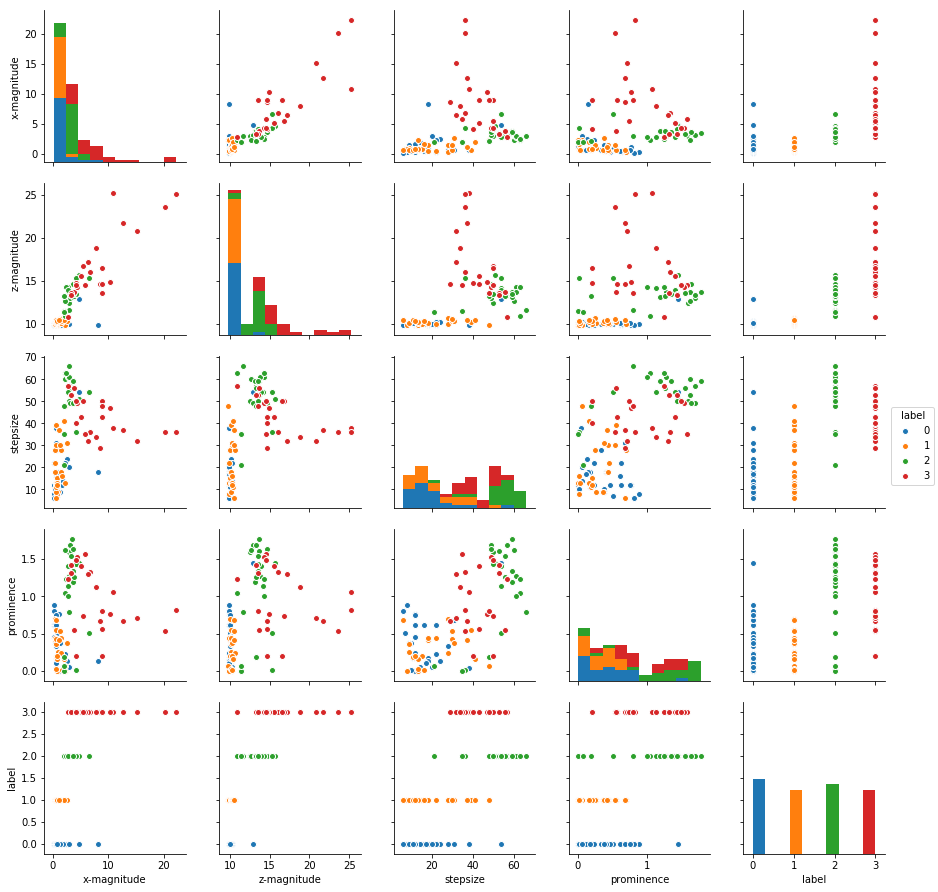

In [37]:
# scatterplots for every combination of features
sns.pairplot(data = final_data, hue = 'label')
plt.show()

Finally, there it is: 98 rows of beautiful, clean data, each consisting of 4 meaningful, distinct features. With each feature plotted against each other in a scatterplot, we can definitely tell that there is correlation and clustering going on, and it seems like I've succesfully cleaned the data of extreme outliers. Now its time to let the algorithm sort all of it out:

At long last, its time to apply some machine learning!

To determine the proper model to use, I will import several different classification models from sci-kit-learn: Decision Tree, Random Forest, K Nearest Neighbors, and Support Vector Machine. 

The data will then be split into a TRAIN and TEST set. Each model will be fit to and optimized for the TRAIN set and then tested against the TEST set. The perforamnce of all the models will be compared, and the best one will be selected!

In [39]:
# importing models and other nessecary sklearn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [41]:
# splitting data into X and y sets
X = final_data.drop(['label'], axis = 1)
y = final_data['label']

In [49]:
# split data into TEST and TRAIN sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [50]:
# Decision Tree Classifier model: fitting, prediction, and evaluation
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
expected = y_test
predicted = model.predict(X_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.57      0.73      0.64        11
          1       0.62      0.45      0.53        11
          2       0.89      0.62      0.73        13
          3       0.44      0.80      0.57         5

avg / total       0.67      0.62      0.63        40

[[8 3 0 0]
 [6 5 0 0]
 [0 0 8 5]
 [0 0 1 4]]


In [51]:
# K Nearest Neighbors Classifier model: fitting, prediction, and evaluation
model = KNeighborsClassifier(n_neighbors = 6)
model.fit(X_train, y_train)
expected = y_test
predicted = model.predict(X_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.50      0.64      0.56        11
          1       0.43      0.27      0.33        11
          2       0.75      0.92      0.83        13
          3       0.67      0.40      0.50         5

avg / total       0.58      0.60      0.58        40

[[ 7  4  0  0]
 [ 7  3  1  0]
 [ 0  0 12  1]
 [ 0  0  3  2]]


In [52]:
# Support Vector Machine Classifier model: fitting, prediction, and evaluation
model = svm.SVC()
model.fit(X_train, y_train)
expected = y_test
predicted = model.predict(X_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.45      0.45      0.45        11
          1       0.40      0.36      0.38        11
          2       0.75      0.46      0.57        13
          3       0.27      0.60      0.37         5

avg / total       0.51      0.45      0.46        40

[[5 6 0 0]
 [6 4 0 1]
 [0 0 6 7]
 [0 0 2 3]]


In [53]:
# Random Forest Classifier model: fitting, prediction, and evaluation
model = RandomForestClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_)
expected = y_test
predicted = model.predict(X_test)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

[0.25236937 0.41698063 0.20619515 0.12445485]
             precision    recall  f1-score   support

          0       0.62      0.91      0.74        11
          1       0.83      0.45      0.59        11
          2       0.83      0.77      0.80        13
          3       0.50      0.60      0.55         5

avg / total       0.73      0.70      0.69        40

[[10  1  0  0]
 [ 6  5  0  0]
 [ 0  0 10  3]
 [ 0  0  2  3]]


After examining the results of the confusion matrix for each of the classification models used, it seems like the Random Forest classifier performed the best, with the highest precision rate (0.73) of the group. However, there is a little more we can do to optimize this model. 

Using GridSearchCV, I will create many Random Forest models with slightly different parameters and see which one performs best in order to optimize the model for this data. 

In [54]:
# grid of possibile inital conditions for Random Forest Classifier
param_grid = {

    'min_samples_split': [3, 4, 5, 7, 10], 

    'n_estimators' : [5, 10, 15, 20, 25, 30],

    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],

    'max_features': [1, 2, 3],

}

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
# fitting many Random Forest models with different starting parameters using GridSearchCV
model = RandomForestClassifier()
model_cv = GridSearchCV(model, param_grid, cv = 5)
model_cv.fit(X_train, y_train)

# print parameters that returned the best scores
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_)) 
print("Best score is {}".format(model_cv.best_score_))

Tuned Random Forest Parameters: {'max_depth': 20, 'max_features': 2, 'min_samples_split': 4, 'n_estimators': 20}
Best score is 0.7758620689655172


In [89]:
# Fine-tuned Random Forest Classifier model: fitting, prediction, and evaluation
model = RandomForestClassifier(max_depth = 20, max_features = 2, min_samples_split = 4, n_estimators = 20)
model.fit(X_train, y_train)
print(model.feature_importances_)
expected = y_test
predicted = model.predict(X_test)
print(metrics.classification_report(expected, predicted))
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
(sum(cm[0][0:2]) + sum(cm[1][0:2]) + sum(cm[2][2:4]) + sum(cm[3][2:4])) / sum(sum(cm))

[0.28237474 0.38033892 0.21664812 0.12063821]
             precision    recall  f1-score   support

          0       0.64      0.82      0.72        11
          1       0.75      0.55      0.63        11
          2       0.92      0.92      0.92        13
          3       0.80      0.80      0.80         5

avg / total       0.78      0.78      0.77        40

[[ 9  2  0  0]
 [ 5  6  0  0]
 [ 0  0 12  1]
 [ 0  0  1  4]]


1.0

After optimizing my model, I was able to achieve 78% precision and 78% recall on a test set of data using a Random Forest classification model. 

Notably, the model also correctly sorted date into the Sit/Stand vs. Walk/Jog supergroups at a perfect 100% accuracy rate. In other words, the model had no errors classifying data into classes with motion vs. without, only errors between sit/stand and walk/jog.

The vast majority of the models' prediction errors came while attempting to delineate between sitting and standing, which is to be expected because the acceleration a phone experiences while its user is standing vs. sitting is extremely similar (near zero an non-periodic in all directions in both cases). 

The applications of an algorithm like this are very apparent: for example, an application like Strava needs to know when the user begins walking/running vs. when they stop for a feature such as auto pause. A feature like this, common in many fitness applications, would only need to split periodic motion actions (walk/run) from stationary actions (sit/stand), which my model did perfectly. 

A huge thanks to Maxim Integrated and specifically my mentor Melih Altun for helping me with this project during my internship. 